In [2]:
from imports import *

In [3]:
class polynomialCp:
    def __init__(self, component):
        
        conn = sqlite3.connect('database.db')
        cursor = conn.cursor()

        cursor.execute('''
            SELECT  a1_cold, a2_cold, a3_cold, a4_cold, a5_cold,
                    a1_hot, a2_hot, a3_hot, a4_hot, a5_hot,
                    minColdTemp, maxColdTemp, minHotTemp, maxHotTemp,
                    MolWeight, Hf0
            FROM termoquimica
            WHERE Component = ?
        ''', (component,))

        data = cursor.fetchone()
        conn.close()

        coefs = [(data[i],  data[i+5]) for i in range(5)]
        temps = [(data[i],  data[i+2]) for i in range(10,12)]
        props = data[14:]

        self.a1_cold, self.a1_hot =  coefs[0]
        self.a2_cold, self.a2_hot =  coefs[1]
        self.a3_cold, self.a3_hot =  coefs[2]
        self.a4_cold, self.a4_hot =  coefs[3]
        self.a5_cold, self.a5_hot =  coefs[4]

        self.minColdTemp, self.maxColdTemp = temps[0]
        self.minHotTemp, self.maxHotTemp = temps[1]

        self.MolWeight, self.Hf0 = props

    def cp(self,T):
        if self.minColdTemp <= T < self.maxColdTemp:
            value = self.R*(
                self.a1_cold +
                self.a2_cold * T +
                self.a3_cold * T**2 +
                self.a4_cold * T**3 +
                self.a5_cold * T**4
            )
        elif self.minHotTemp <= T < self.maxHotTemp:
            value = self.R*(
                self.a1_hot +
                self.a2_hot * T +
                self.a3_hot * T**2 +
                self.a4_hot * T**3 +
                self.a5_hot * T**4
            )
        else:
            value = 0
        return value
        


In [10]:
reac = [(5,'H2'),(1,'O2')]
prod = [(2,'H2O'), (3,'H2')]

# Extraer los números


def integration(f,a,b,h):
    return h * ( (f(a) + f(b))/2 + sum([f(a + k*h) for k in range(1, int((b - a)/h))]))

def adiabaticTemp_calc(reac, prod, t0, tGuess, hStep):

    reac_moles = [item[0] for item in reac]
    prod_moles = [item[0] for item in prod]

    reac_comps = [polynomialCp(item[1]) for item in reac]
    prod_comps = [polynomialCp(item[1]) for item in prod]

    hf0_reac = sum([n * r.Hf0 for n,r in zip(reac_moles,reac_comps)])
    hf0_prod = sum([n * p.Hf0 for n,p in zip(prod_moles,prod_comps)])
    
    def heat_balance(t):

        hCp_reac = sum([n * integration(r.cp, 298, t0, hStep) for n,r in zip(reac_moles,reac_comps)])
        hCp_prod = sum([n * integration(p.cp, 298, t,  hStep) for n,p in zip(prod_moles,prod_comps)])

        Q_Disp = hf0_reac + hCp_reac
        Q_Req  = hf0_prod + hCp_prod

        delta = (Q_Disp - Q_Req)
        return delta
    

    def newton_raphson(f, x0, tol=hStep, max_iter=10000, h=hStep):
        """
        Método de Newton-Raphson para encontrar las raíces de una función.

        Args:
        f: función objetivo.
        x0: valor inicial para la raíz.
        tol: tolerancia para la convergencia.
        max_iter: número máximo de iteraciones.
        h: paso pequeño para la derivada numérica.

        Returns:
        La raíz aproximada de la función.
        """
        def fp(f, x, h):
            return (f(x + h) - f(x - h)) / (2 * h)

        x = x0
        for i in range(max_iter):
            fx = f(x)
            dfx = fp(f, x, h)

            if dfx == 0:
                raise ValueError("Derivada nula. El método de Newton-Raphson no puede continuar.")

            x_new = x - fx / dfx

            if abs(x_new - x) < tol:
                return x_new

            x = x_new

        raise ValueError("El método de Newton-Raphson no convergió en el número máximo de iteraciones.")

    prodMol         = sum([n for n in prod_moles])
    tSol            = newton_raphson(heat_balance, tGuess)
    molWeight_prod  = (sum([n * r.MolWeight for n,r in zip(prod_moles,prod_comps)]) / prodMol)*1e-3
    cp_Mass         =  (sum([n * r.cp(tSol) for n,r in zip(prod_moles,prod_comps)]) / prodMol) / molWeight_prod
    R_prod          = 8.31446261815324/molWeight_prod
    cv_Mass         = cp_Mass - R_prod
    gamma           = cp_Mass/(cp_Mass - R_prod)

    return tSol, cp_Mass, molWeight_prod, cp_Mass, cv_Mass, R_prod, gamma

adiabaticTemp_calc(reac, prod, 300, 1000, 1)

(2833.177846183625,
 5283.948034423712,
 0.00841564,
 5283.948034423712,
 4295.970576006617,
 987.9774584170948,
 1.2299777060706696)

In [1]:
from imports import *

def newtonRaph(f, x0, tol, max_iter, h):
    """
    Método de Newton-Raphson para encontrar las raíces de una función.
    Args:
    f: función objetivo.
    x0: valor inicial para la raíz.
    tol: tolerancia para la convergencia.
    max_iter: número máximo de iteraciones.
    h: paso pequeño para la derivada numérica.
    Returns:
    La raíz aproximada de la función.
    """
    def fp(f, x, h):
        return (f(x + h) - f(x - h)) / (2 * h)

    x = x0
    for i in range(max_iter):
        fx = f(x)
        dfx = fp(f, x, h)

        if dfx == 0:
            return print("Error", "Derivada nula. El método de Newton-Raphson no puede continuar.")

        x_new = x - fx / dfx

        if abs(x_new - x) < tol:
            return x_new

        x = x_new

    return print("Error", "El método de Newton-Raphson no convergió en el número máximo de iteraciones.")



class TubularGrain:
    def __init__(self, inputs):
        # Lista de atributos que quieres asignar
        attributes = [
            "rIn_0b", "rOut", "rThrt", "lComb", "rho_b",
            "a", "n", "gamma", "R", "T1", "P0", "delta_r"
        ]
        
        for attr, value in zip(attributes, inputs):
            setattr(self, attr, value)
        
        self.P, self.G, self.M, self.t = self.combTime()

    def combTime(self):

        C = (((np.pi * self.rThrt**2 * self.gamma) / (self.rho_b * self.a * 1e-2)))
        R = np.sqrt( (2/(self.gamma + 1))**((self.gamma - 1)/(self.gamma + 1)) / (self.gamma * self.R * self.T1) )

        rt = np.arange(self.rIn_0b, self.rOut + self.delta_r, self.delta_r)
        size = len(rt)

        P  = np.zeros(size)
        G  = np.zeros(size)
        dt = np.zeros(size)
        m  = np.zeros(size)


        def Ab(ti):
            return 2 * np.pi * self.lComb * rt[ti]

        def M(ti):
            return np.pi * self.rho_b * self.lComb * (self.rOut**2 - rt[ti]**2)

        P[0] = self.P0
        G[0] = Ab(0) * self.rho_b * self.a * P[0]**self.n * 1e-2
        dt[0] = (M(0) - M(1)) / G[0]
        m[0] = M(0)

        def iterCalc(ti):
            P_i = ((C / Ab(ti)) * R)**(1/(self.n - 1))
            G_i = Ab(ti) * self.rho_b * self.a * P_i**self.n * 1e-2
            m_i = M(ti)
            dt_i = (M(ti - 1) - M(ti)) / G_i
            return P_i, G_i, m_i ,dt_i

        for i in range(1, size-1):
            P[i], G[i], m[i], dt[i] = iterCalc(i)
        P[-1], G[-1], m[-1] = self.P0, 0, 0

        return P, G, m, np.cumsum(dt)
    
    def engineGraph(self):
        # Crear una figura y un eje
        fig, ax = plt.subplots()
    
        # Dibujar los círculos exteriores e interiores
        outer_circle = plt.Circle((0, 0), self.rOut, color='r', fill=False, label='Outer Radius')
        inner_circle = plt.Circle((0, 0), self.rIn_0b, color='b', fill=False, label='Initial Inner Radius')
    
        # Añadir los círculos al gráfico
        ax.add_artist(outer_circle)
        ax.add_artist(inner_circle)
    
        # Rellenar el área entre el círculo interior y exterior
        theta = np.linspace(0, 2 * np.pi, 100)
        x_outer = self.rOut * np.cos(theta)
        y_outer = self.rOut * np.sin(theta)
        x_inner = self.rIn_0b * np.cos(theta)
        y_inner = self.rIn_0b * np.sin(theta)
        ax.fill(np.concatenate([x_outer, x_inner[::-1]]), 
            np.concatenate([y_outer, y_inner[::-1]]), 
            color='k', alpha=0.5)
       
       # Definir un conjunto de colores
        colors = ['tab:red', 'tab:blue', 'tab:green']
        num_colors = len(colors)

        # Dibujar las líneas radiales internas
        radii = np.linspace(self.rIn_0b, self.rOut, int(1/self.delta_r))
        for i, r in enumerate(radii):
            color = colors[i % num_colors]
            circle = plt.Circle((0, 0), r, color=color, linestyle='-', fill=False)
            ax.add_artist(circle)
        
    
        # Establecer los límites del gráfico
        ax.set_xlim(-self.rOut * 1.1, self.rOut * 1.1)
        ax.set_ylim(-self.rOut * 1.1, self.rOut * 1.1)
    
        # Establecer el aspecto del gráfico para que sea igual
        ax.set_aspect('equal')
    
        # Añadir título y leyenda
        ax.set_title('Cross-Sectional View of the Rocket Motor')
    
        # Mostrar el gráfico
        plt.show()
            
                
            
        



In [7]:
inputs = [0.5, 1, 0.25, 8, 1800, 0.01356, 0.3, 1.15, 223, 1800, 101325, 1e-4]
# Crear una instancia de TubularGrain
grain = TubularGrain(inputs)

# Llamar al método engineGraph para mostrar el dibujo
grain.t

array([2.32310454e-02, 3.41662376e-02, 4.51004931e-02, ...,
       4.65122885e+01, 4.65204148e+01, 4.65204148e+01])

In [55]:
import customtkinter as ctk
from PIL import Image

# Crear la ventana principal
root = ctk.CTk()
root.geometry("400x300")
root.title("CustomTkinter OptionMenu with Images")

# Función para manejar la selección del menú
def option_menu_callback(choice):
    print(f"Selected option: {choice}")
    selected_label.configure(text=f"Selected: {choice}")

# Cargar imágenes (asegúrate de que las imágenes estén en la misma carpeta o proporciona la ruta correcta)
img1 = ctk.CTkImage(light_image=Image.open("image1.png"), size=(50, 50))
img2 = ctk.CTkImage(light_image=Image.open("image2.png"), size=(50, 50))
img3 = ctk.CTkImage(light_image=Image.open("image3.png"), size=(50, 50))

# Crear una lista de opciones con imágenes
options = [("Option 1", img1), ("Option 2", img2), ("Option 3", img3)]

# Variable para almacenar la opción seleccionada
selected_option = ctk.StringVar(value="Select an Option")

# Frame para contener el menú personalizado
menu_frame = ctk.CTkFrame(root)
menu_frame.pack(pady=20)

def show_menu():
    for widget in menu_frame.winfo_children():
        widget.destroy()
    for option, image in options:
        button = ctk.CTkButton(menu_frame, text=option, image=image, compound="left",
                               command=lambda opt=option: [option_menu_callback(opt), hide_menu()])
        button.pack(fill='x')

def hide_menu():
    for widget in menu_frame.winfo_children():
        widget.destroy()

# Botón para mostrar el menú
show_menu_button = ctk.CTkButton(root, textvariable=selected_option, command=show_menu)
show_menu_button.pack(pady=20)

# Label para mostrar la opción seleccionada
selected_label = ctk.CTkLabel(root, text="Selected: None")
selected_label.pack(pady=20)

# Ejecutar el bucle principal de la ventana
root.mainloop()

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\tkinter\__init__.py", line 1968, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\site-packages\customtkinter\windows\widgets\ctk_button.py", line 554, in _clicked
    self._command()
  File "C:\Users\marco\AppData\Local\Temp\ipykernel_14664\2966626305.py", line 33, in show_menu
    button = ctk.CTkButton(menu_frame, text=option, image=image, compound="left",
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\site-packages\customtkinter\windows\widgets\ctk_button.py", line 106, in __init__
    self._draw()
  File "c:\Users\marco\AppData\Local\Programs\Python\Python312\Lib\site-packages\customtkinter\windows\widgets\ctk_button.py", line 264, in _draw
    self._update_image()  

KeyboardInterrupt: 

C:\Users\marco\AppData\Local\Temp\ipykernel_9552\3064651681.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


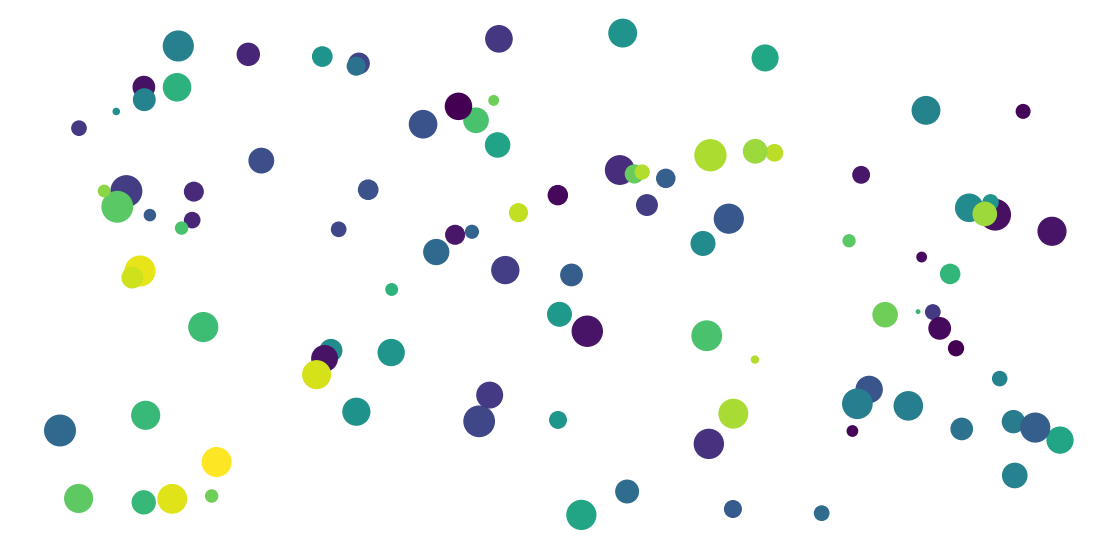

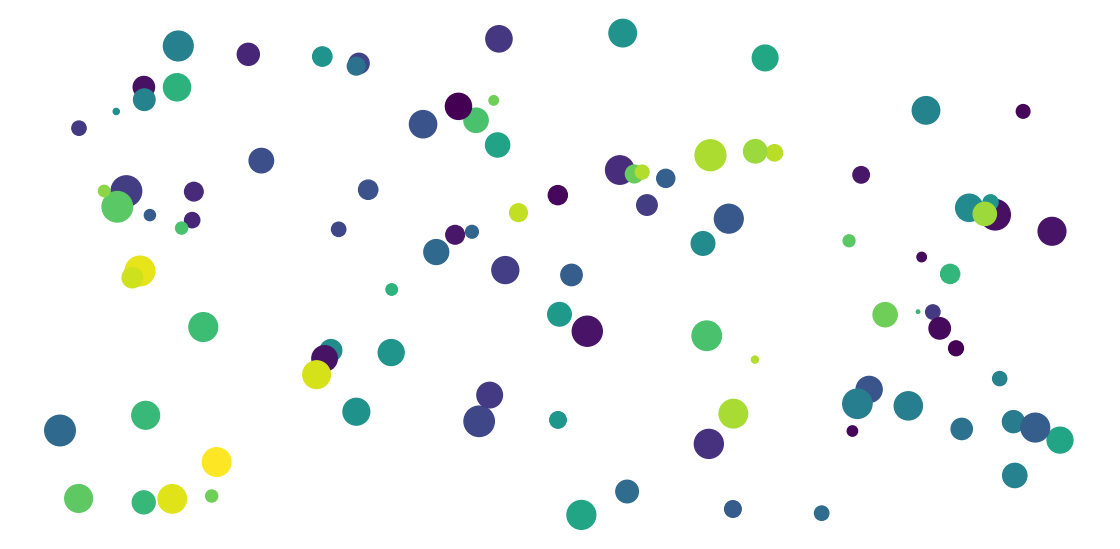

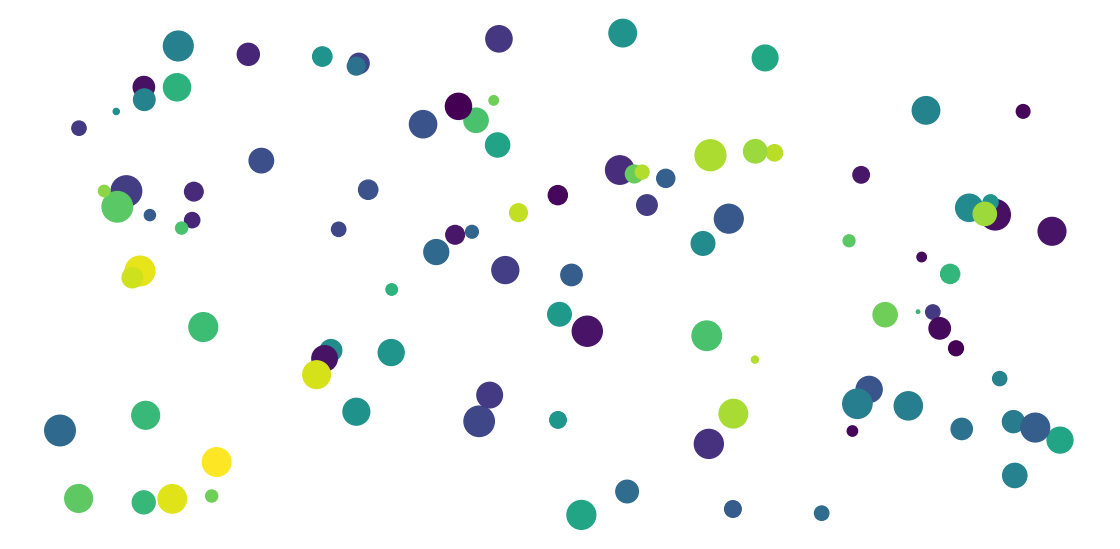

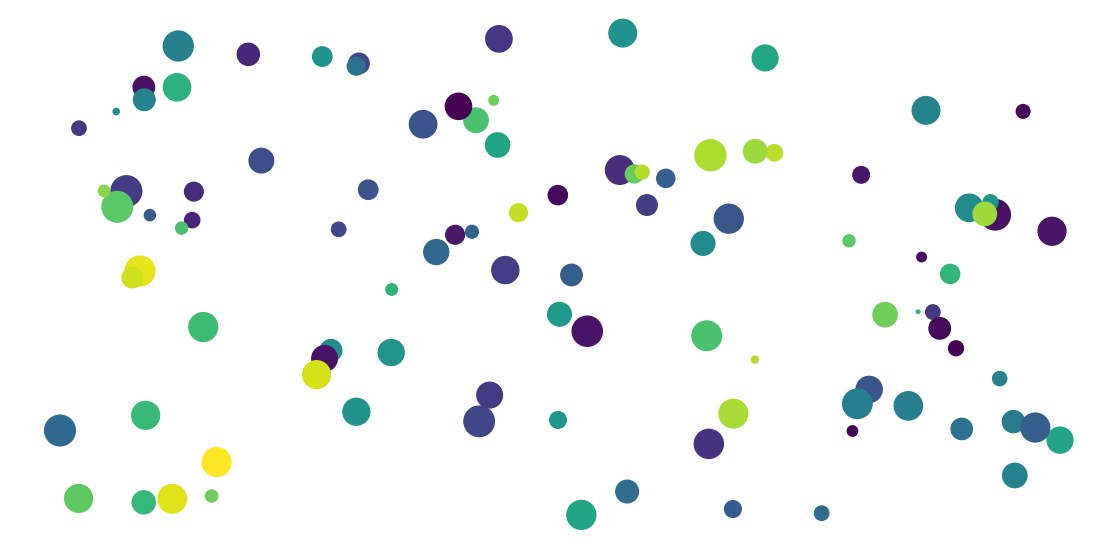

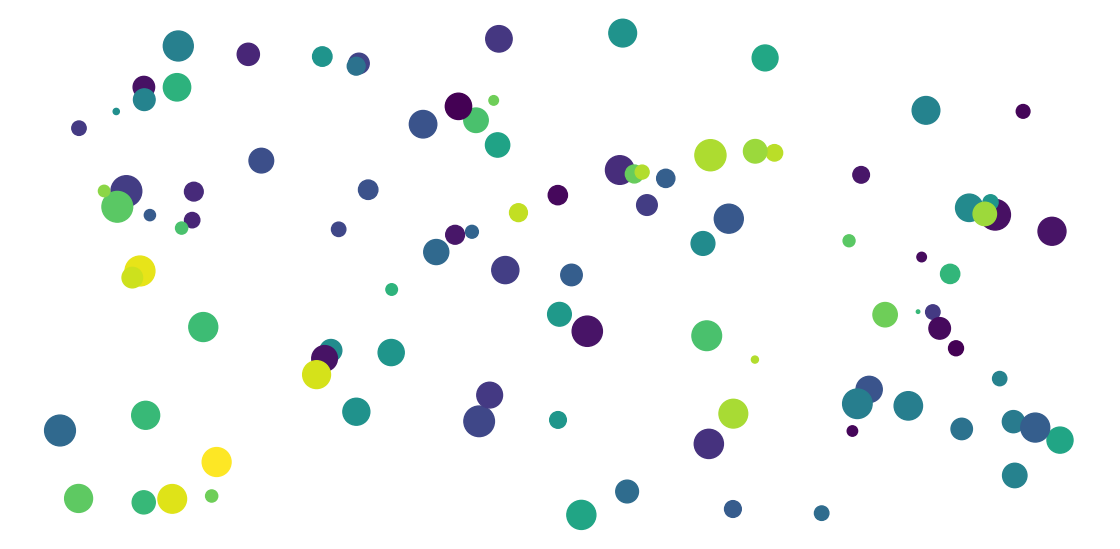

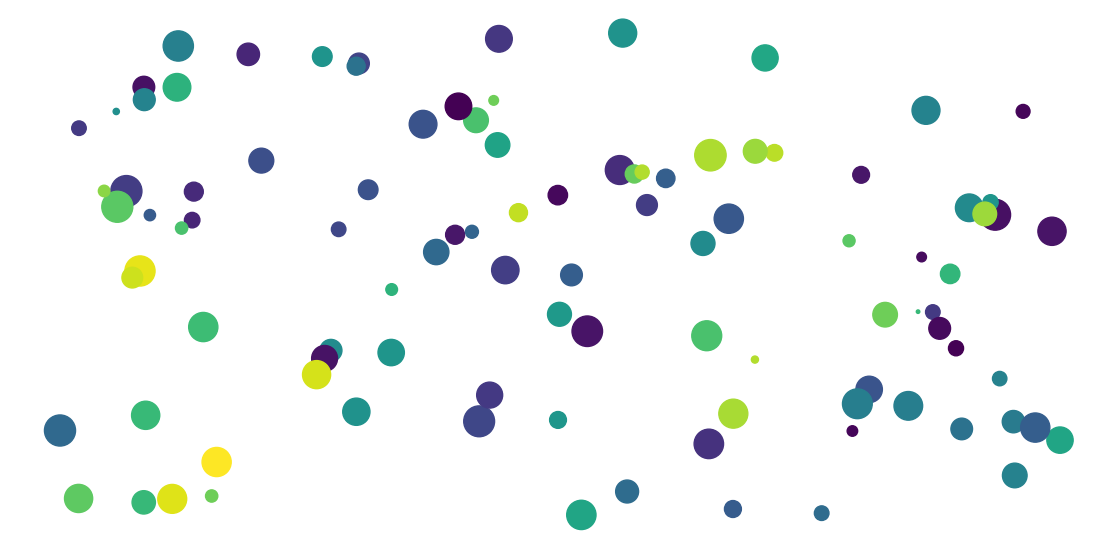

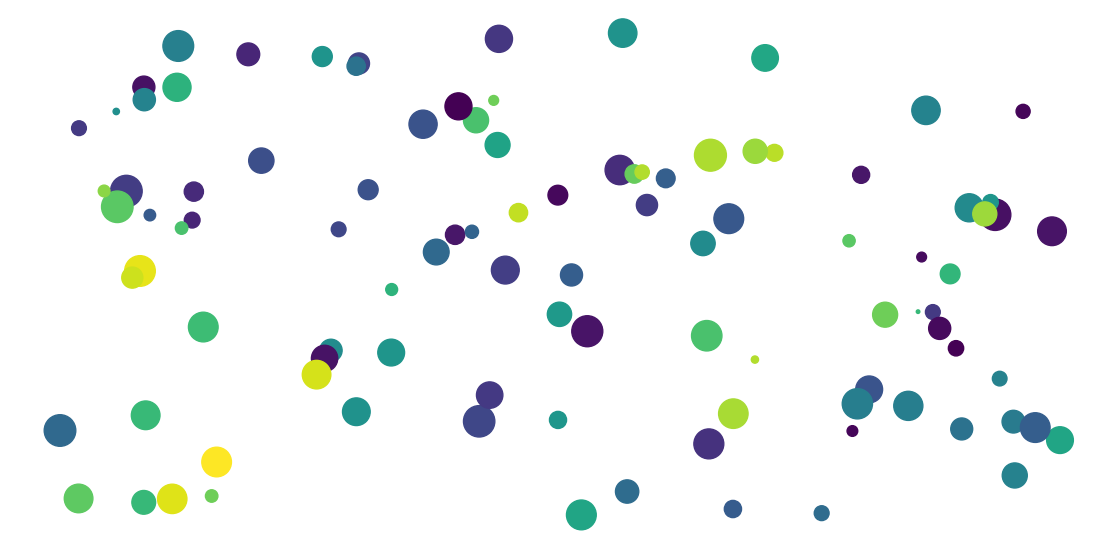

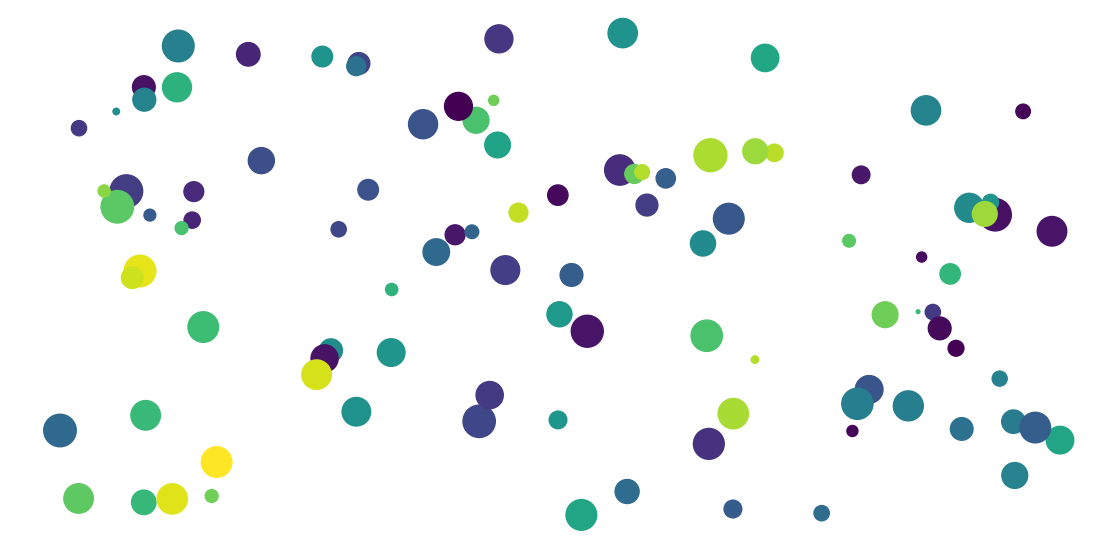

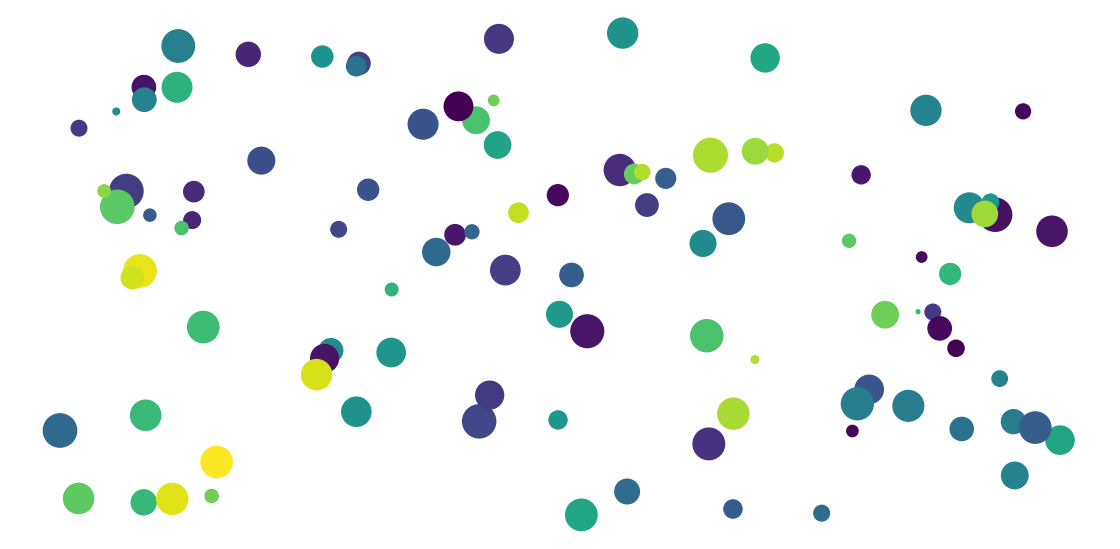

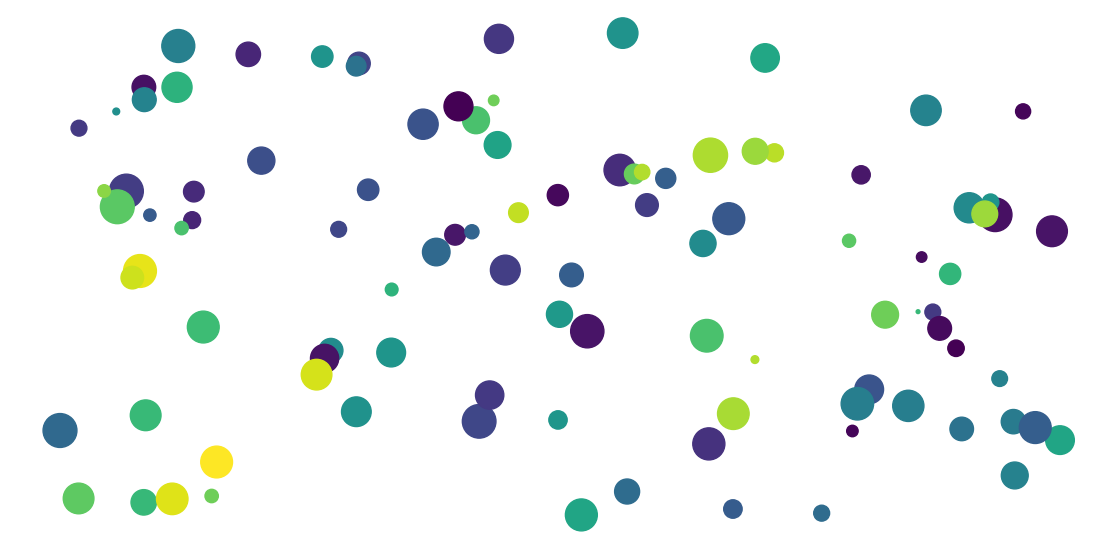

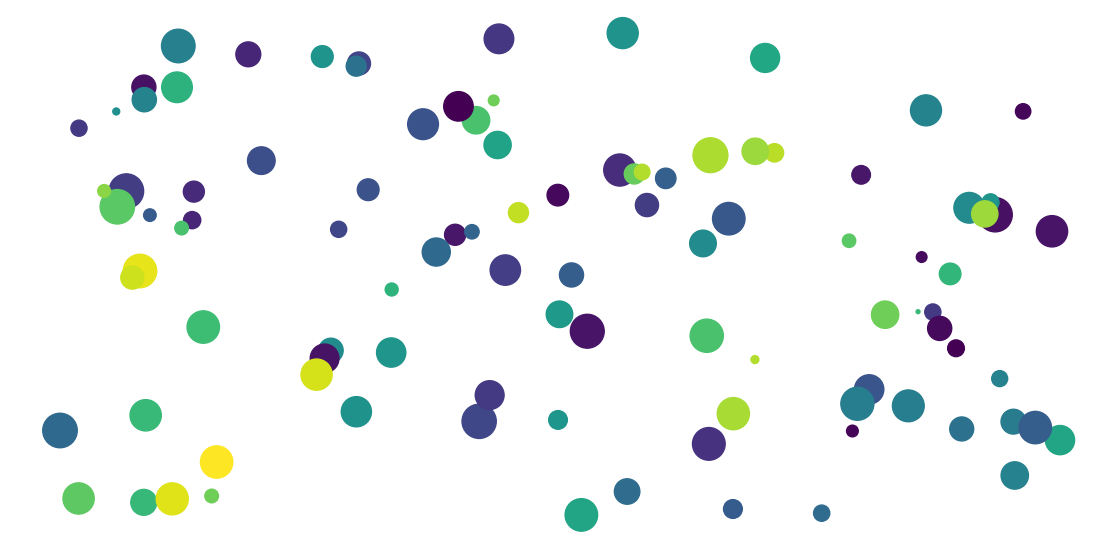

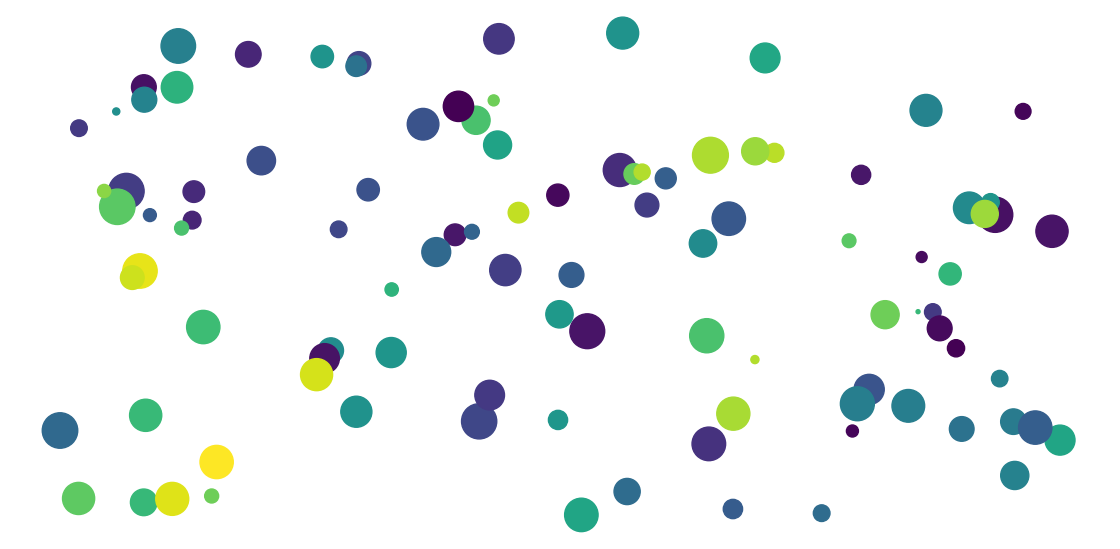

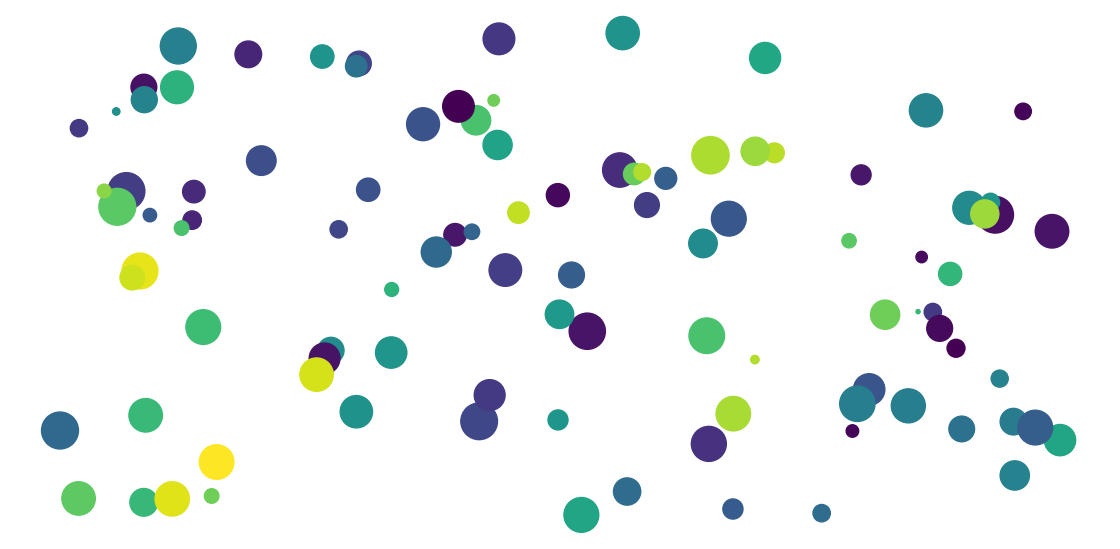

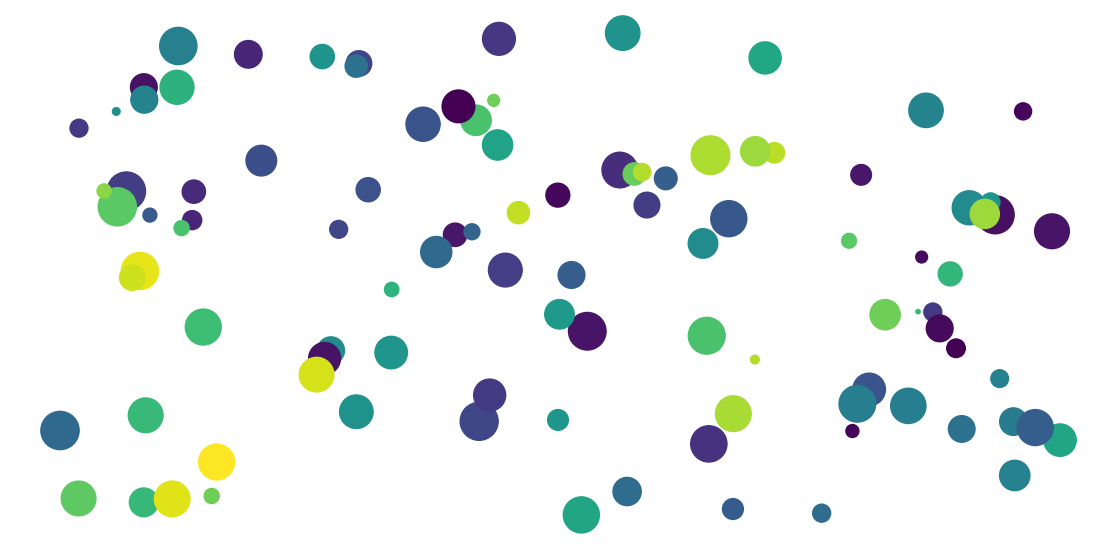

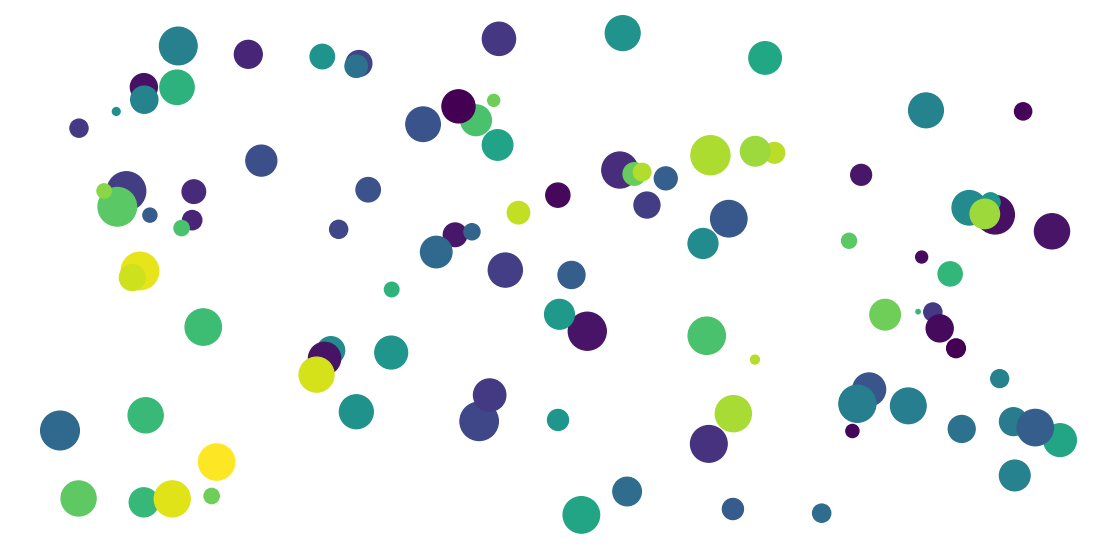

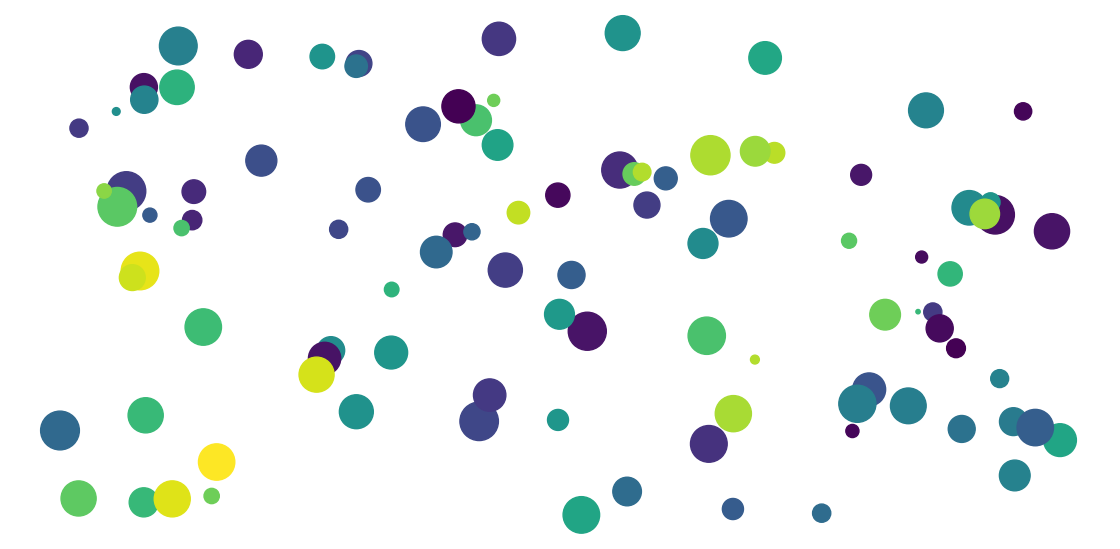

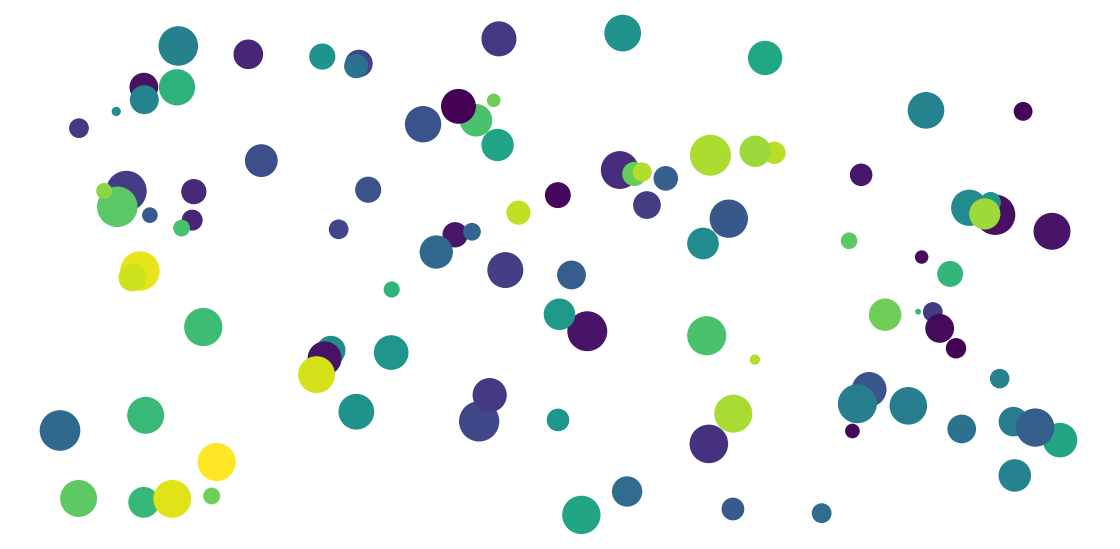

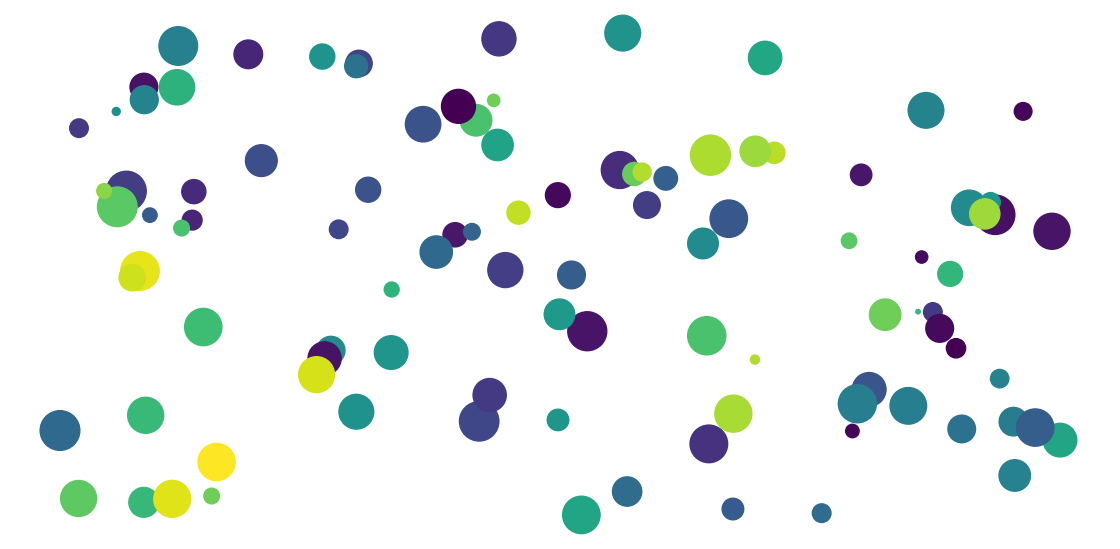

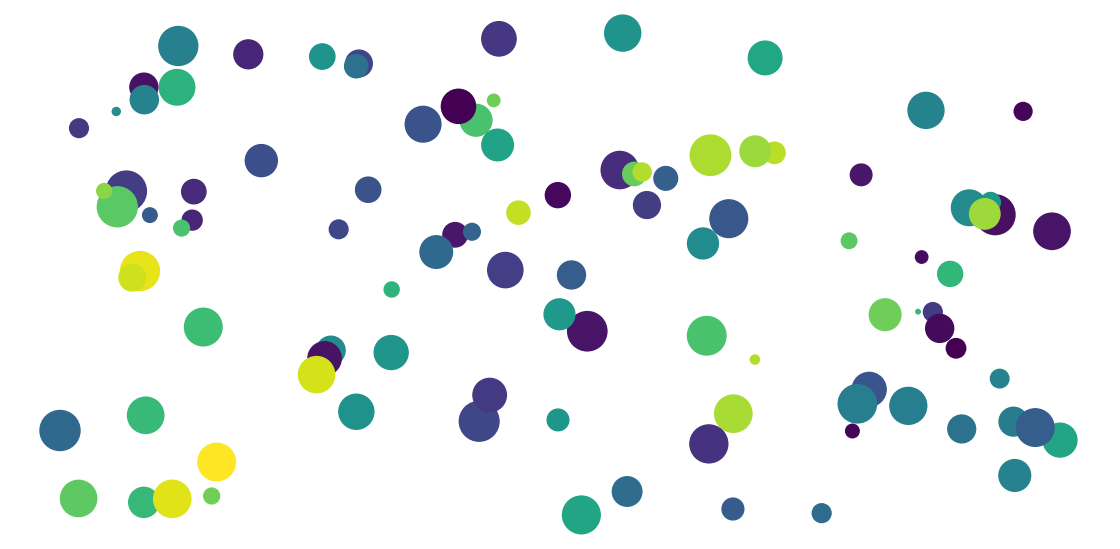

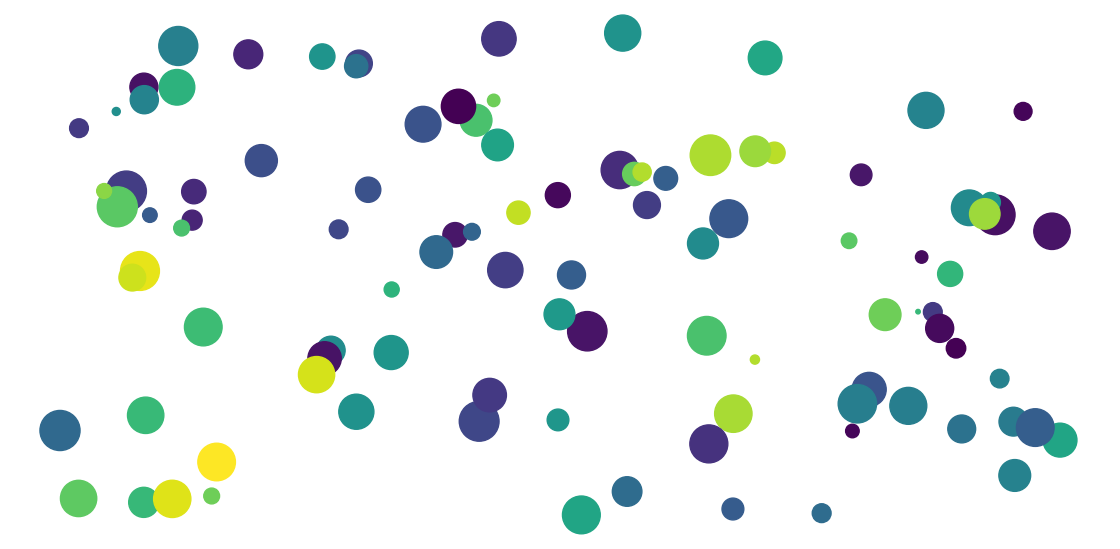

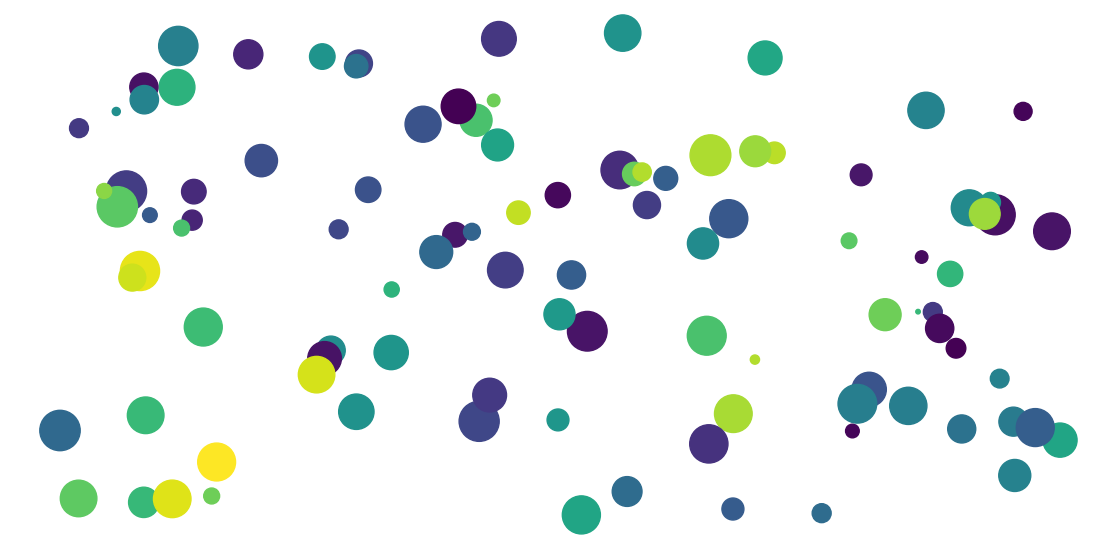

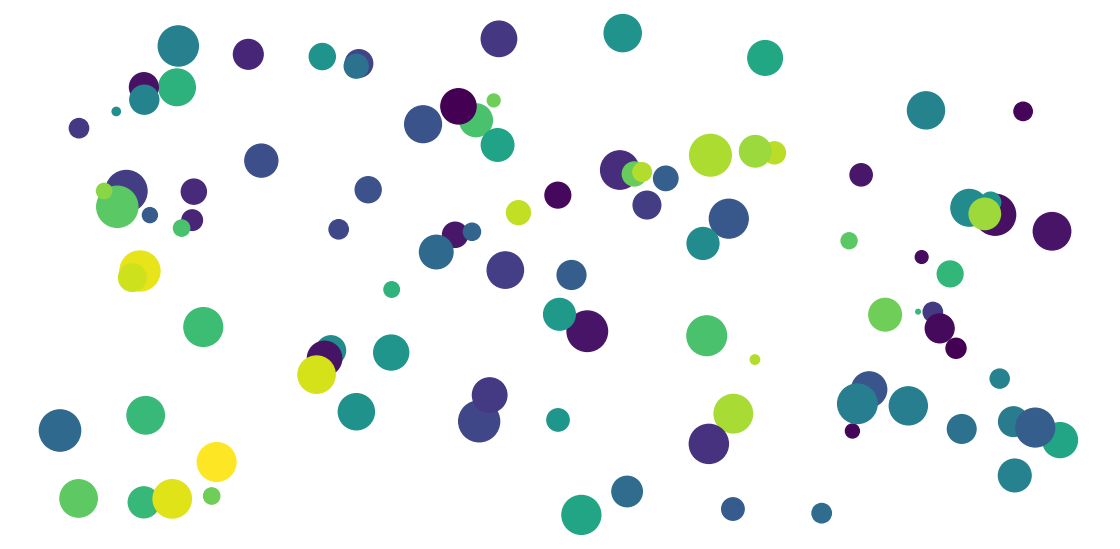

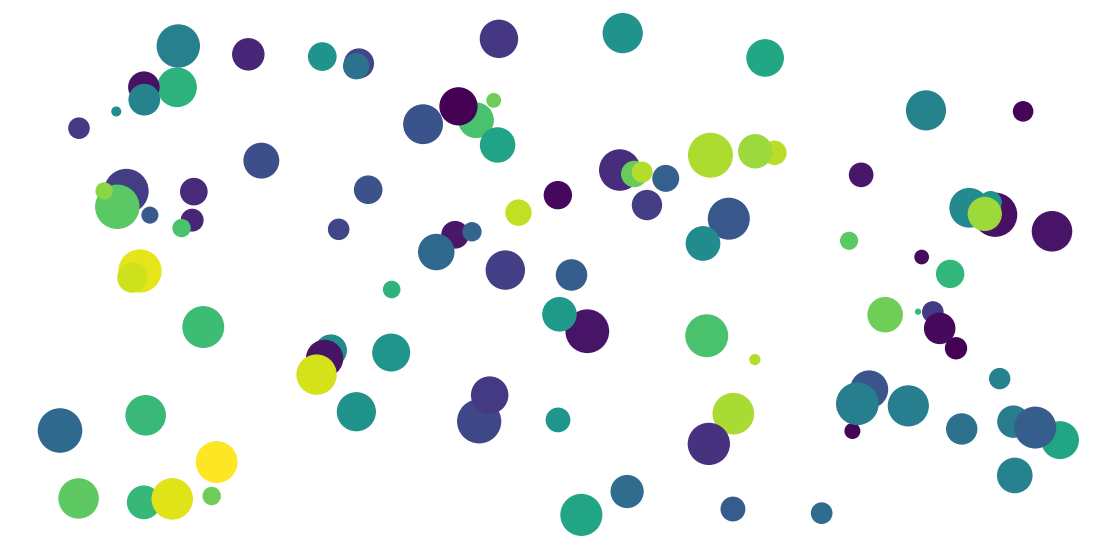

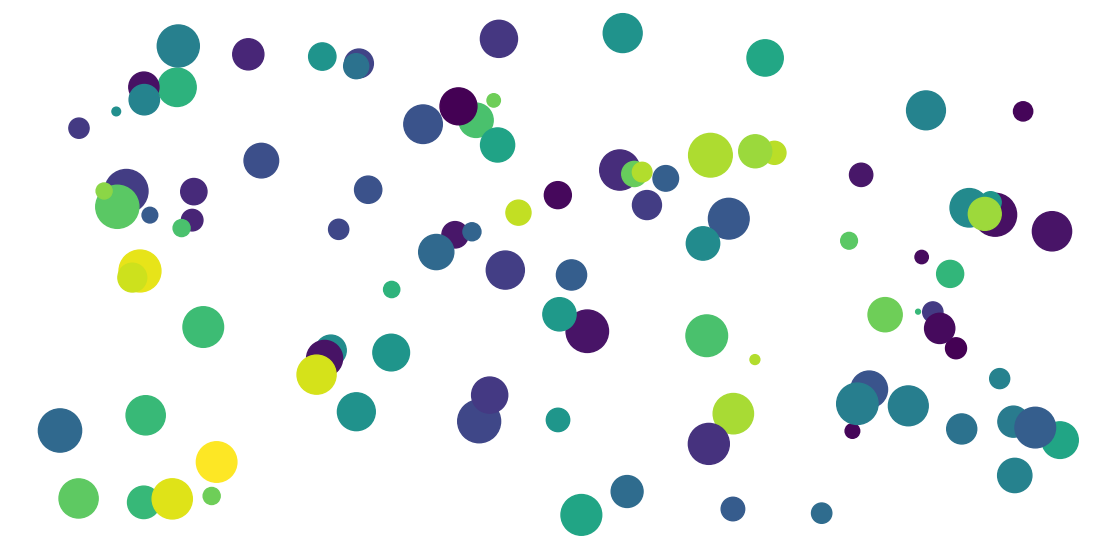

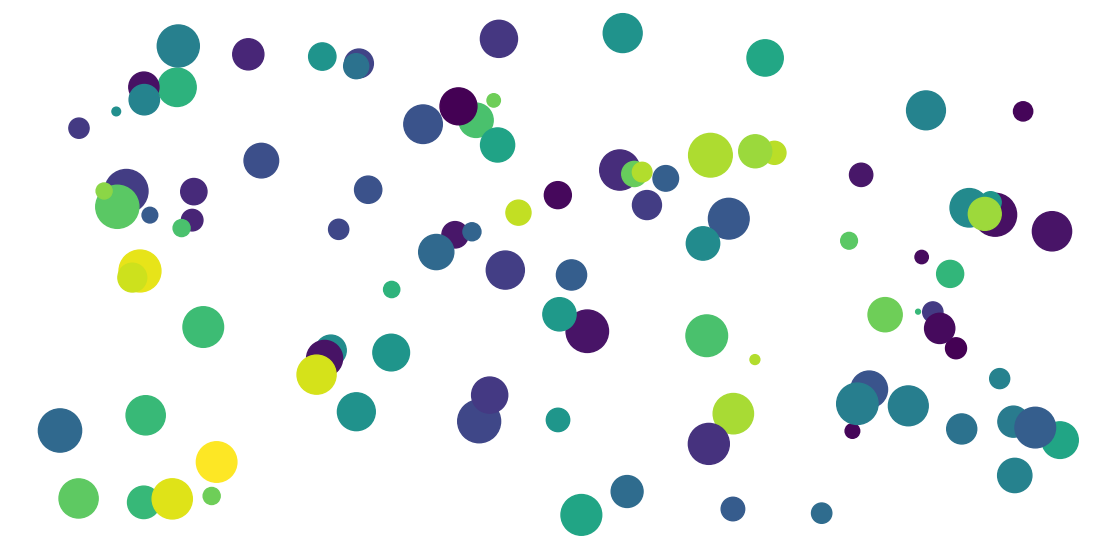

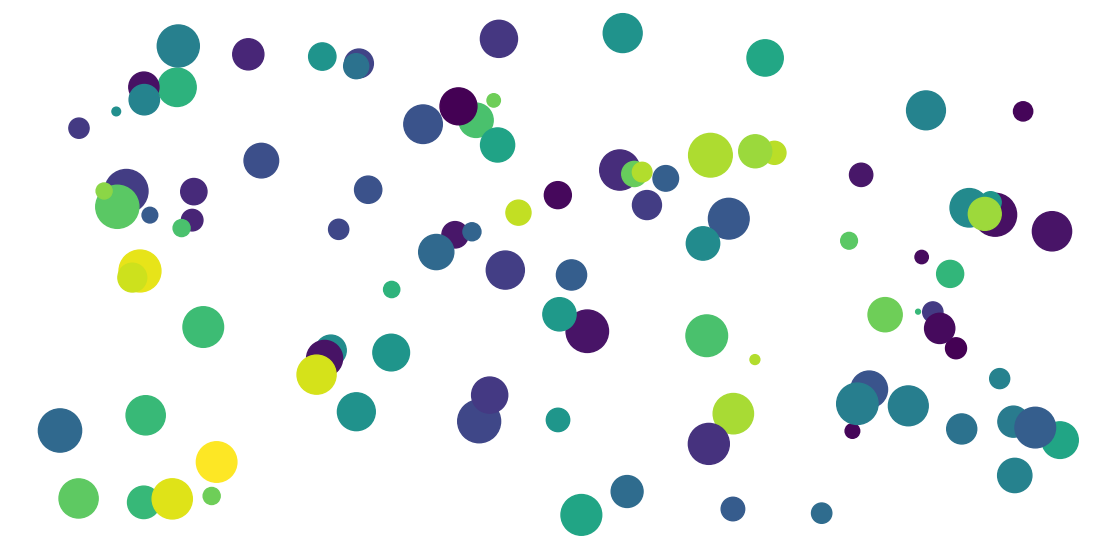

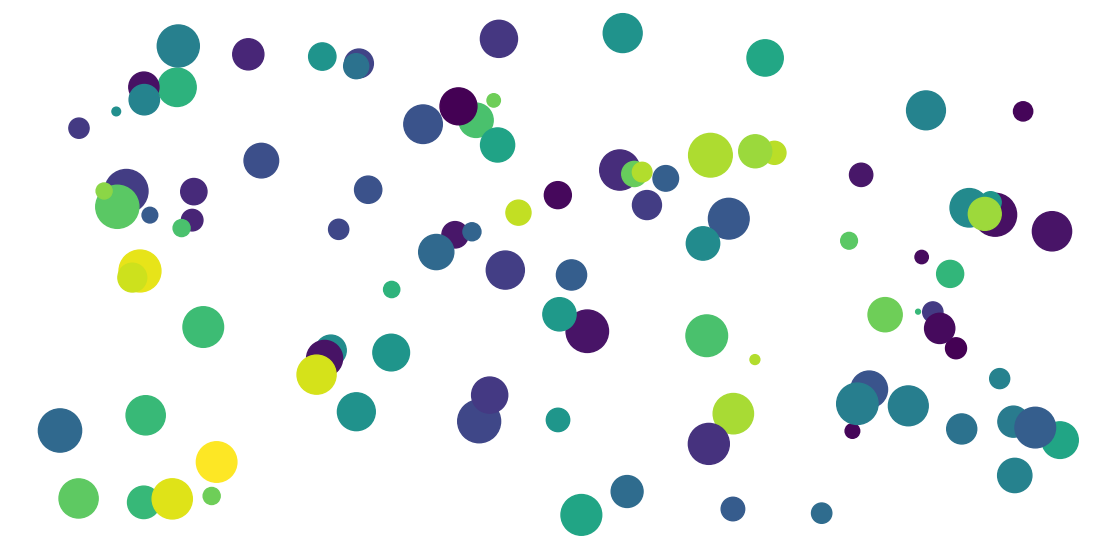

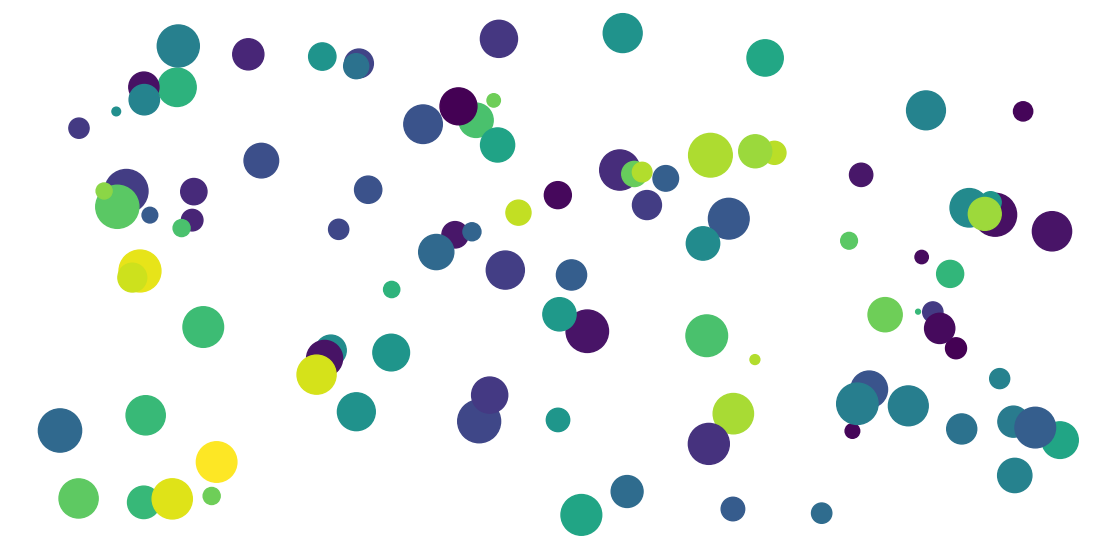

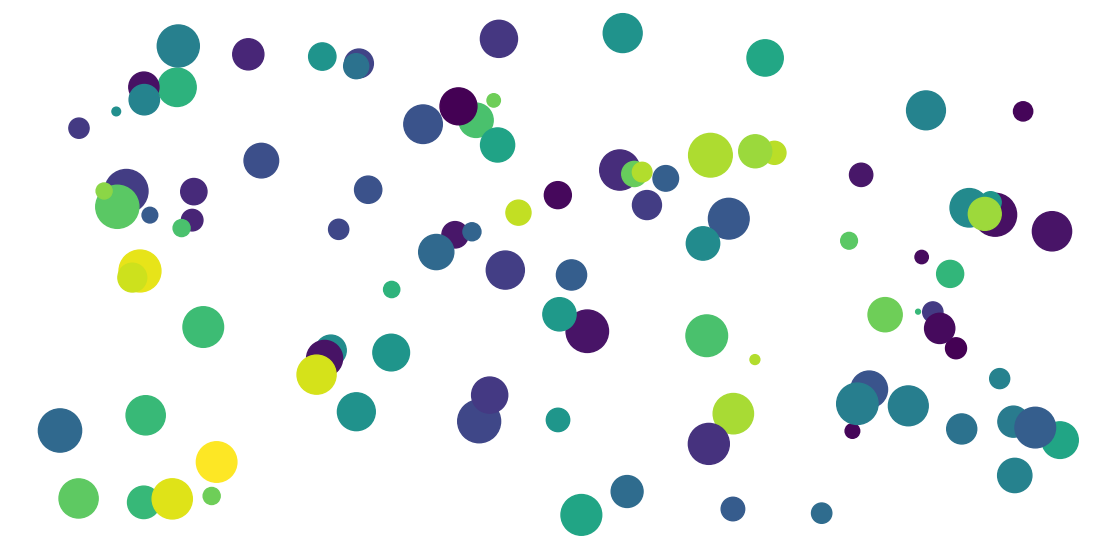

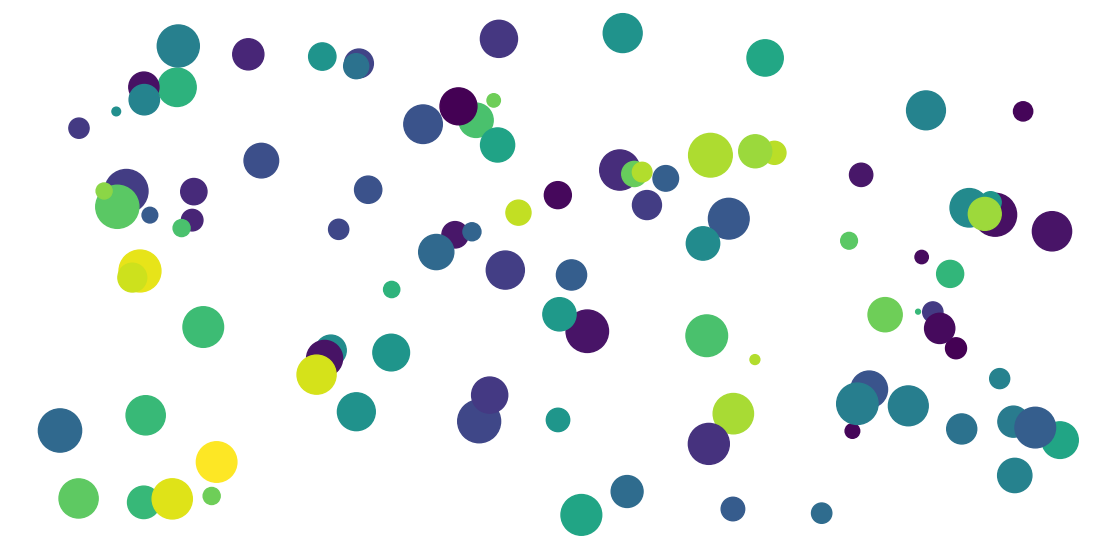

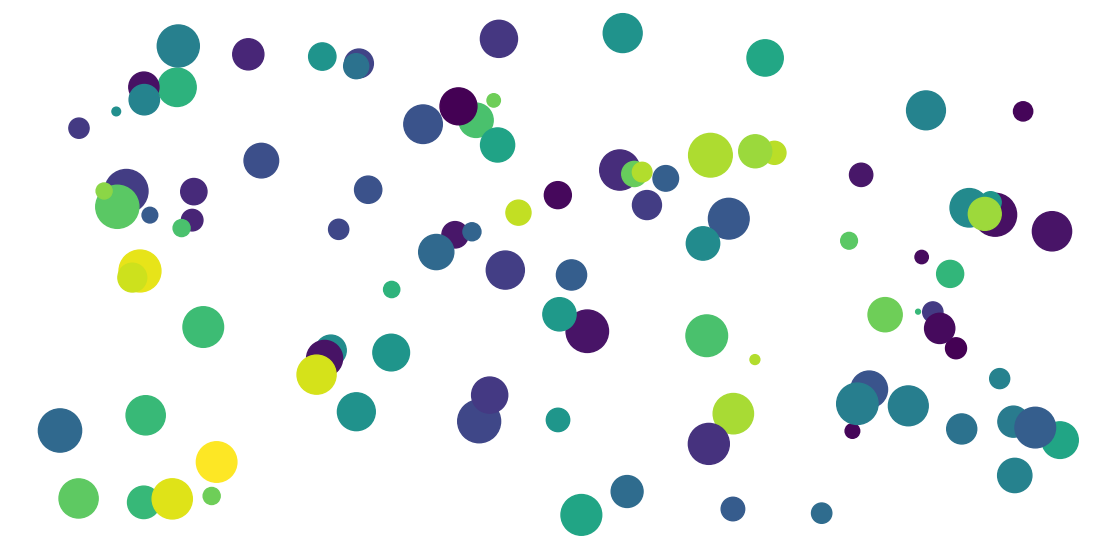

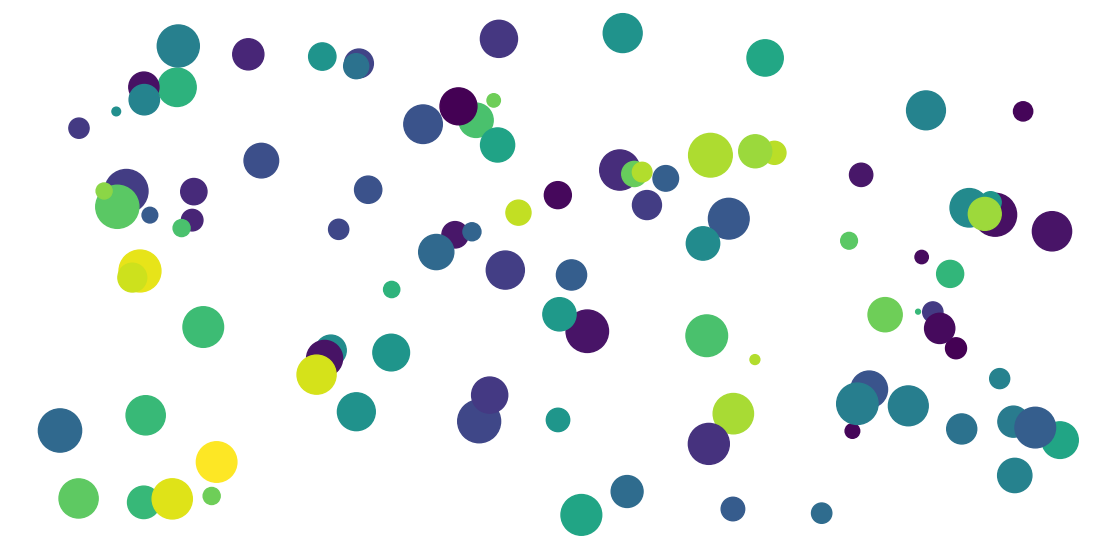

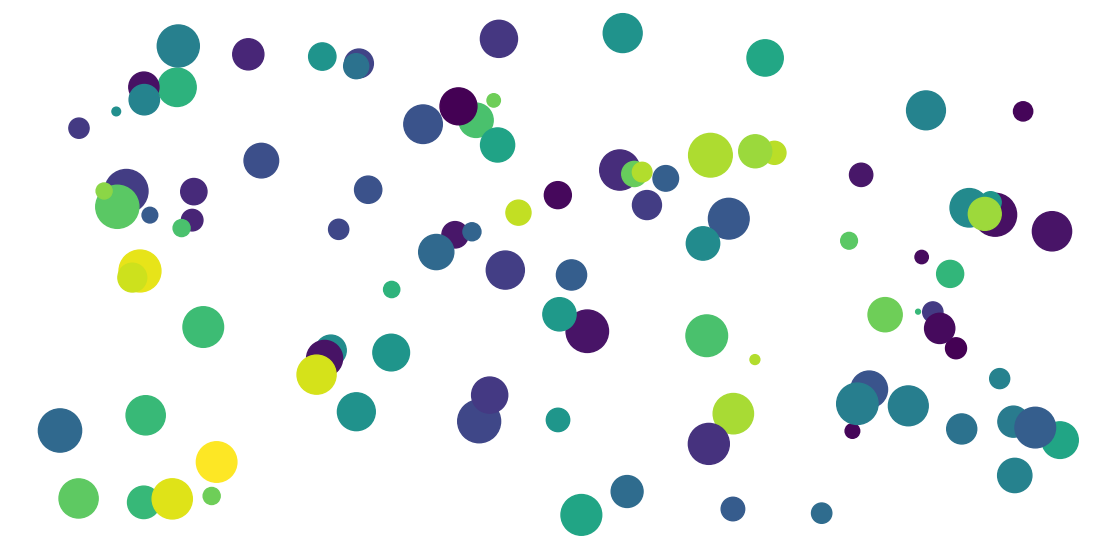

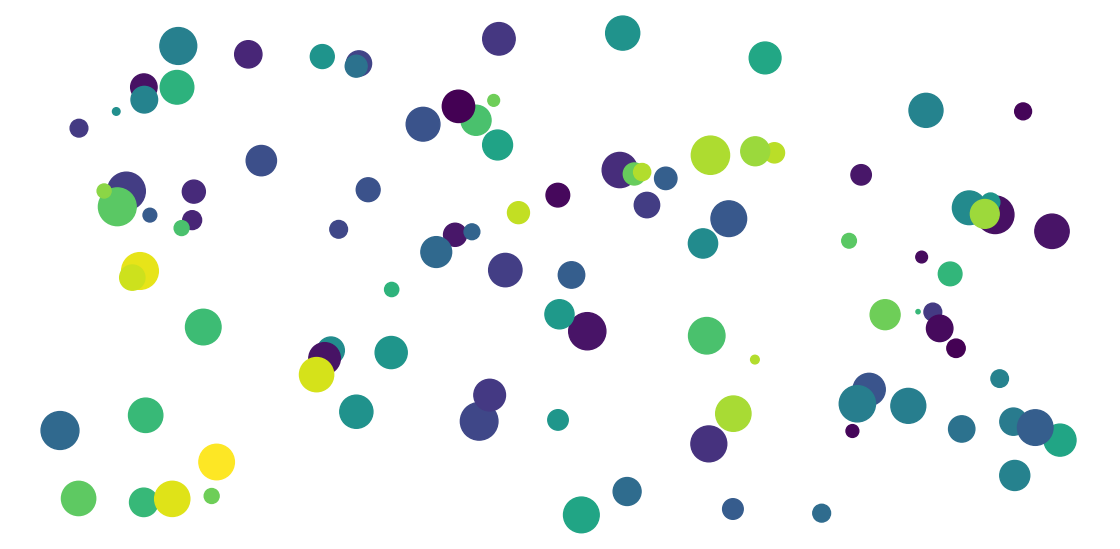

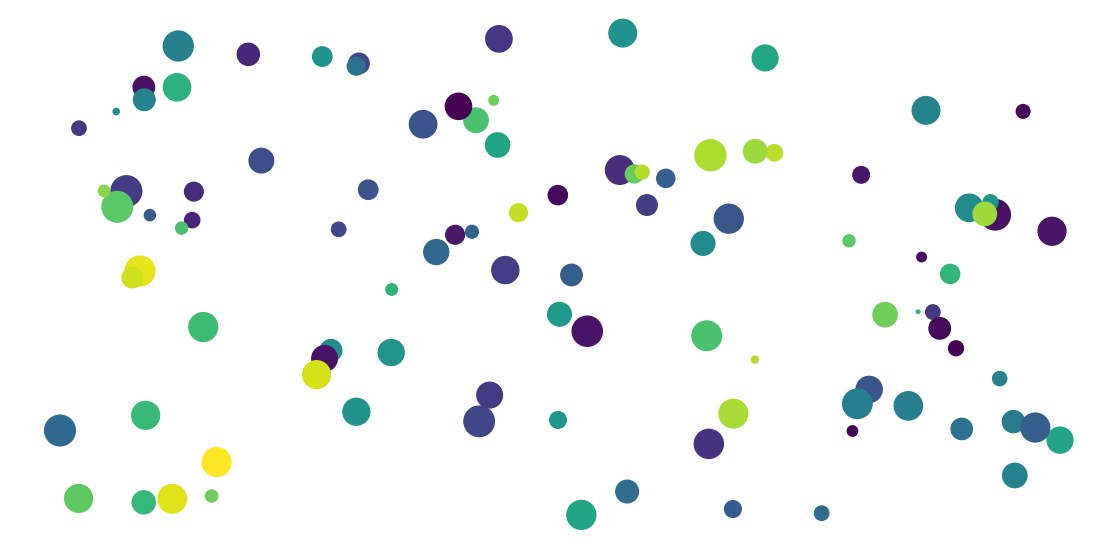

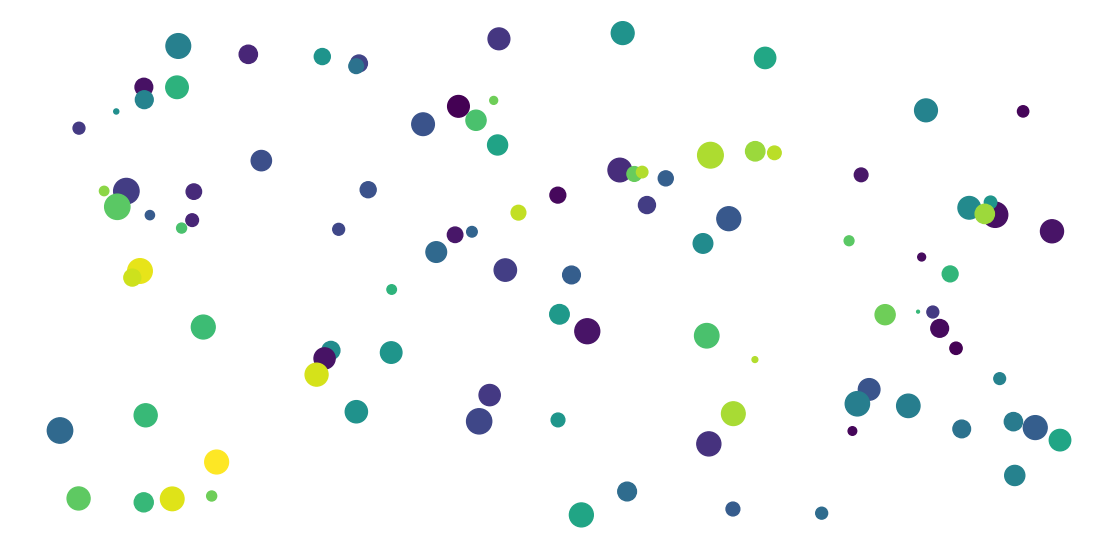

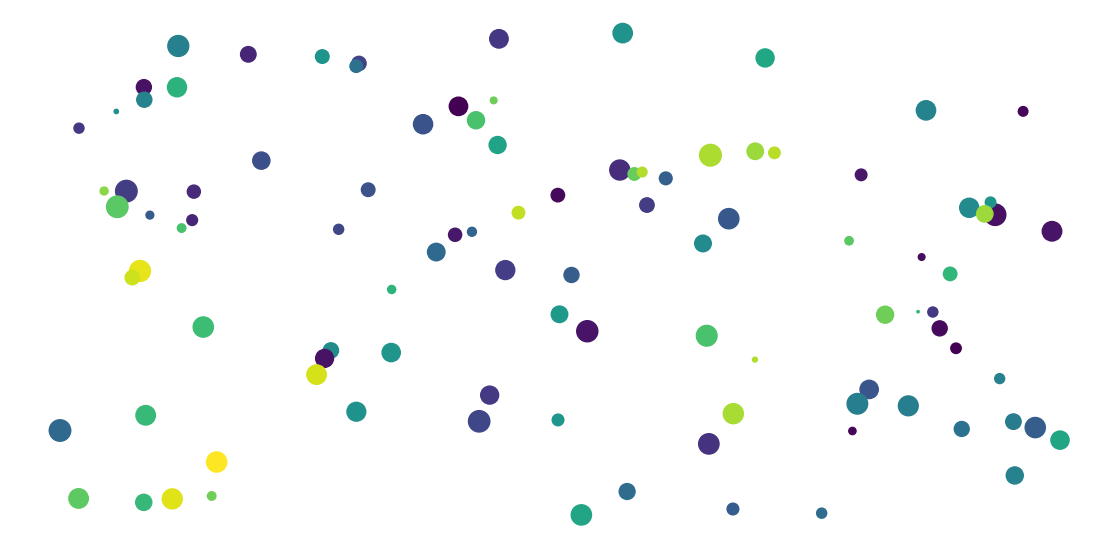

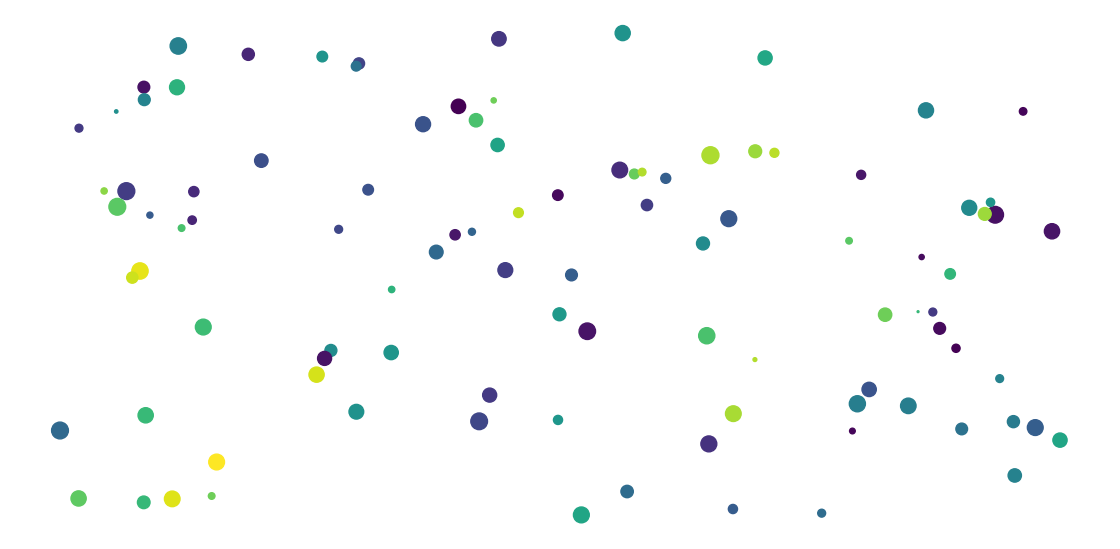

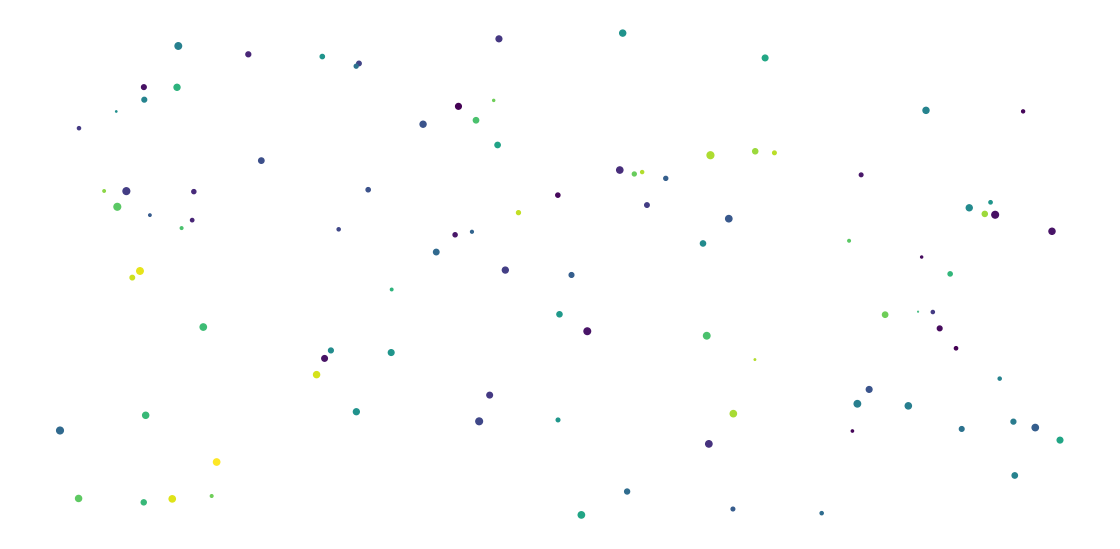

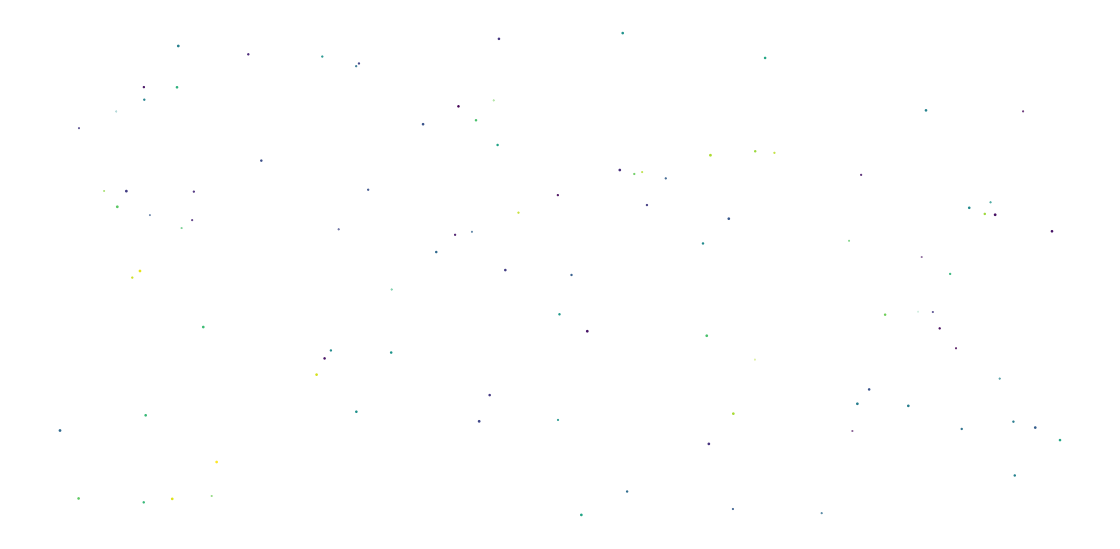

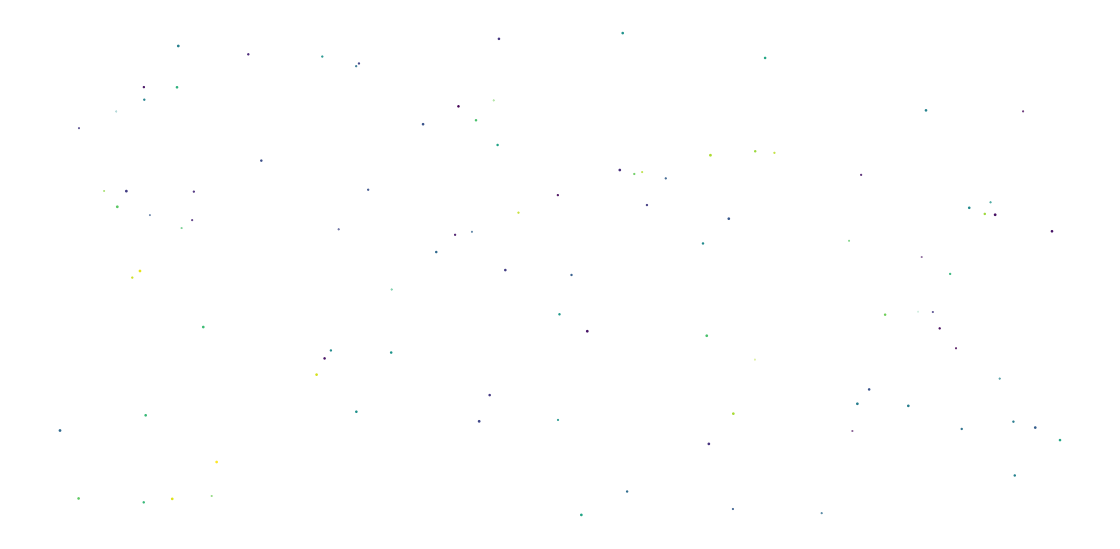

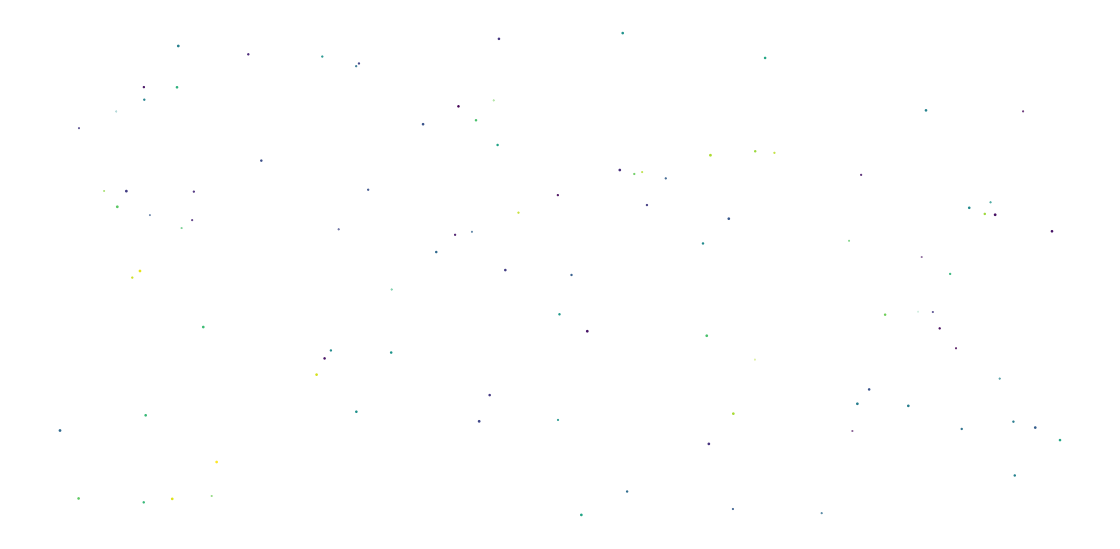

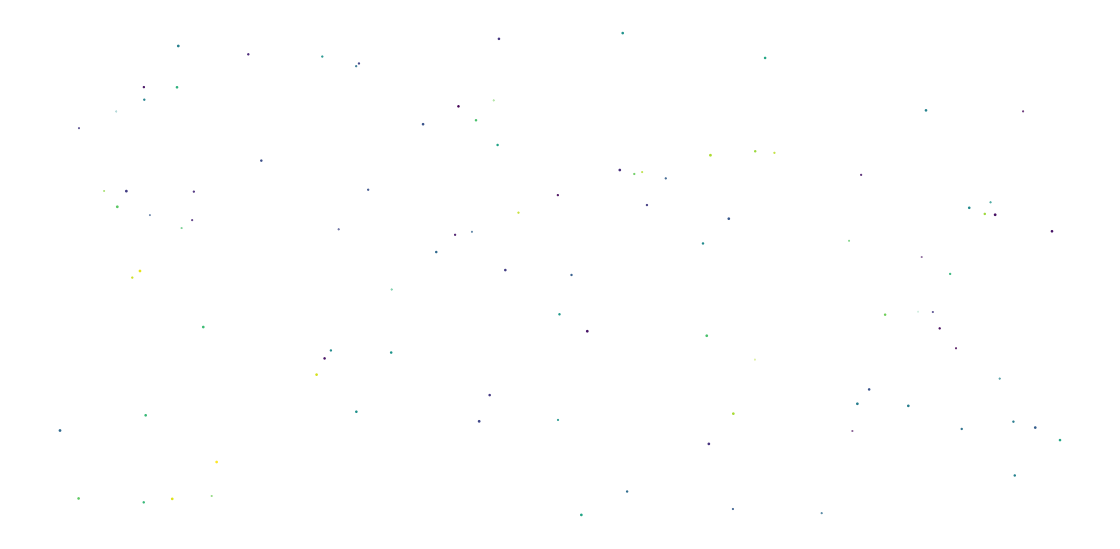

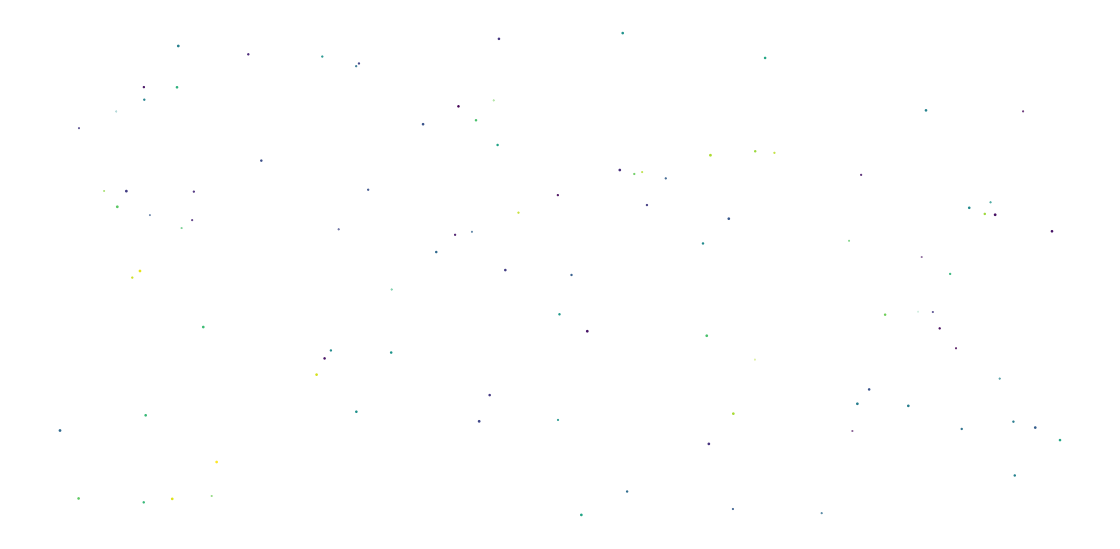

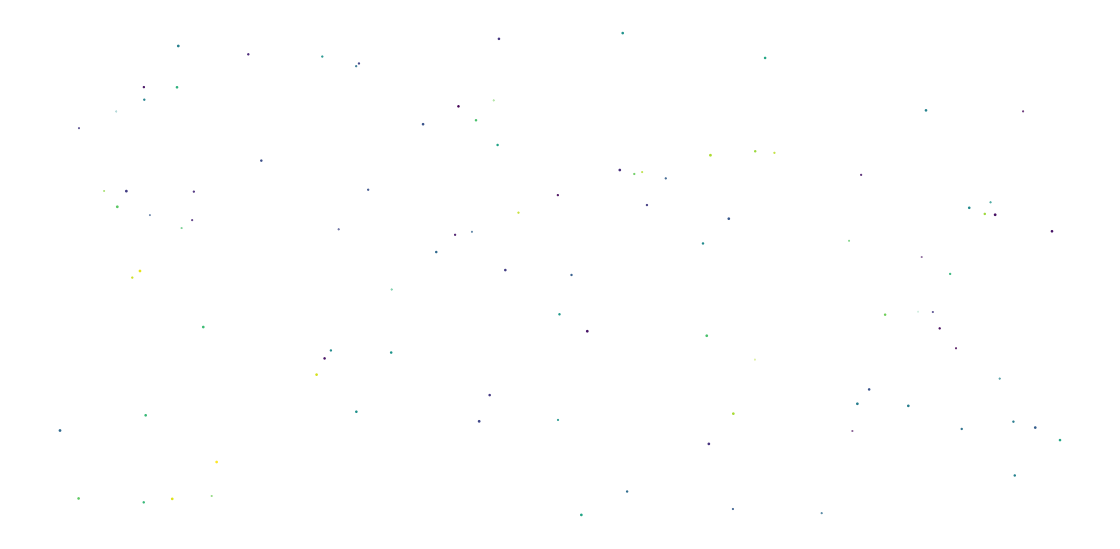

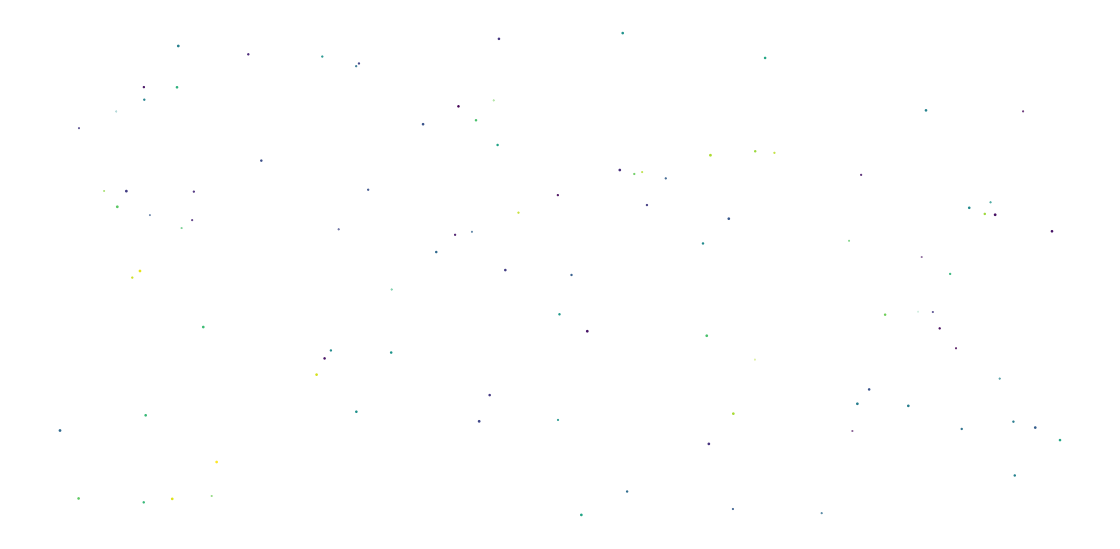

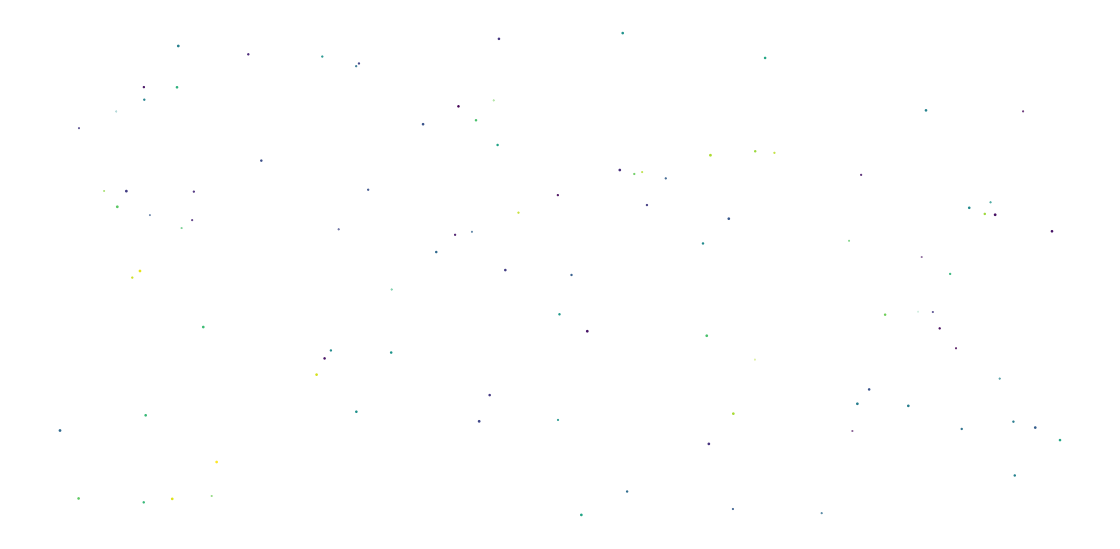

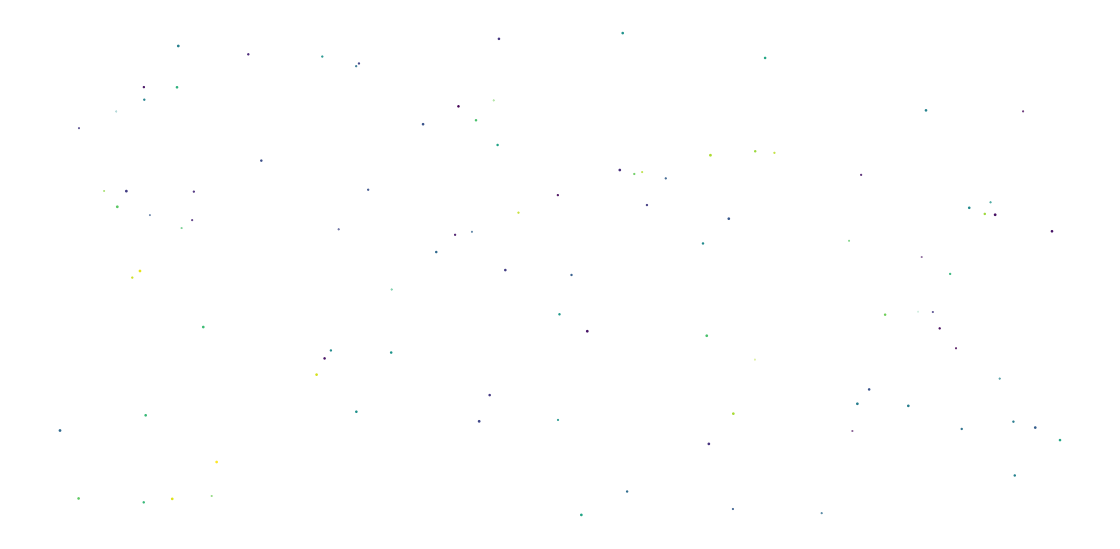

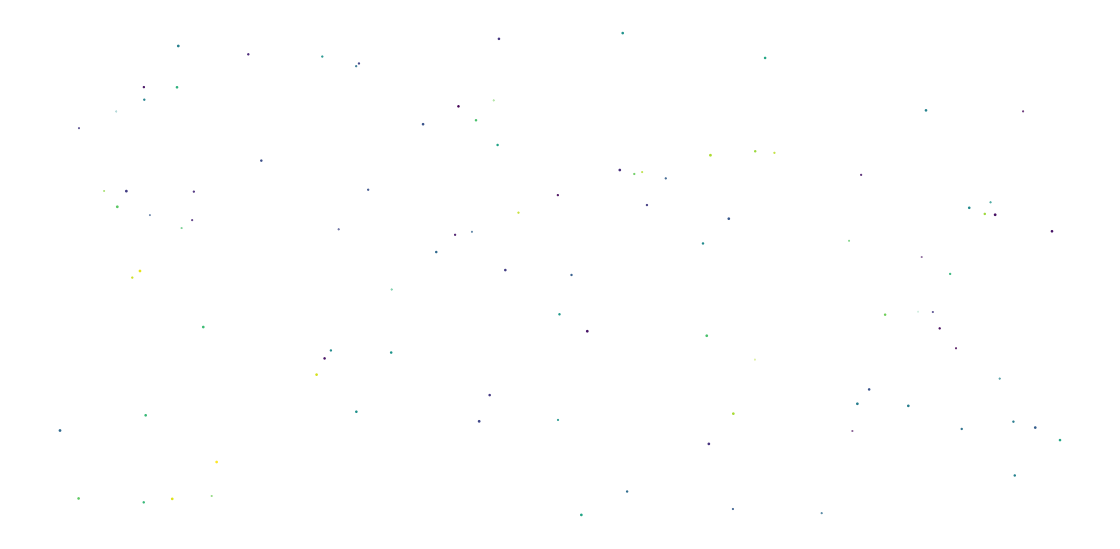

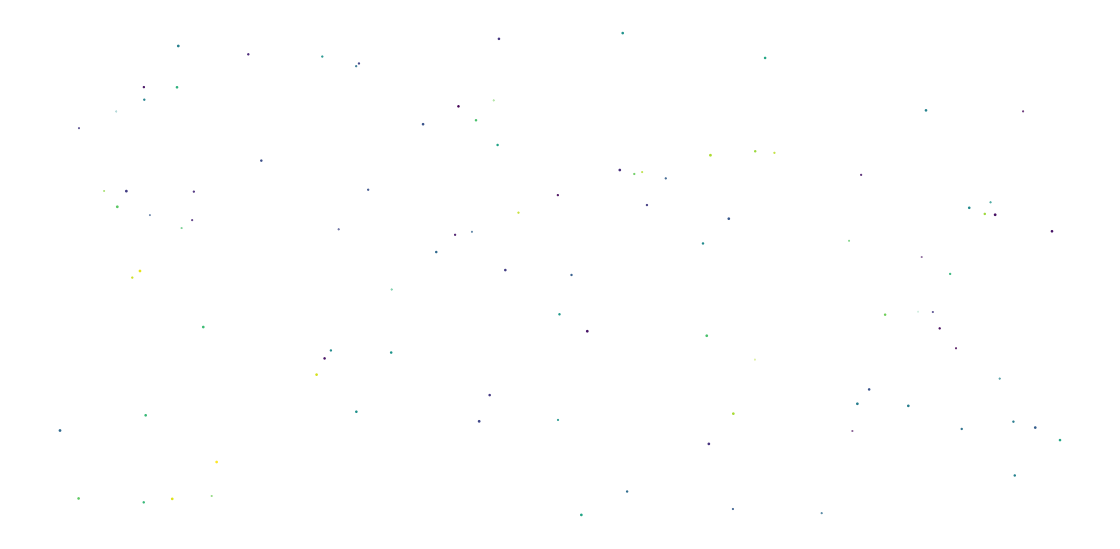

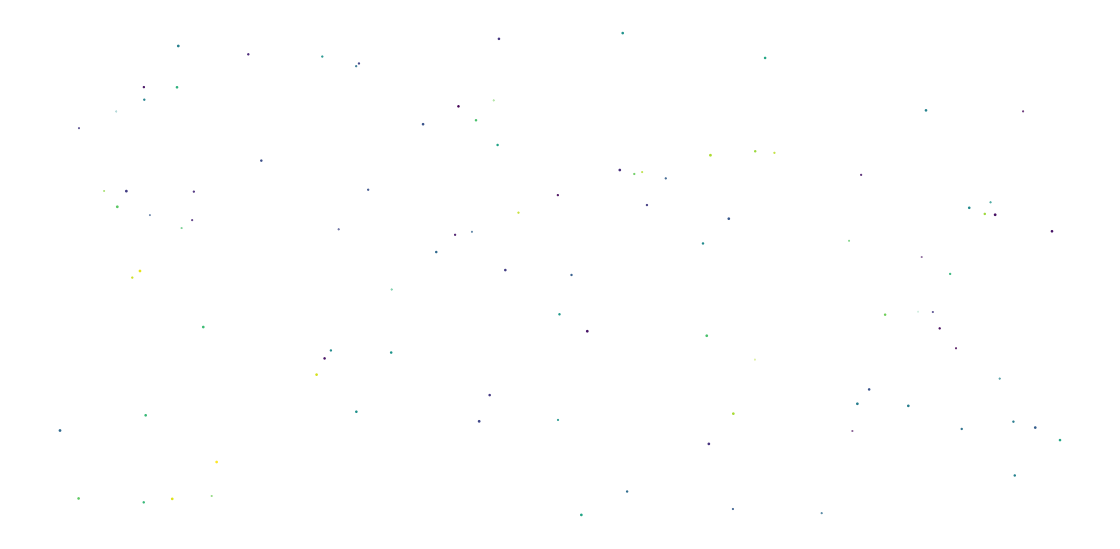

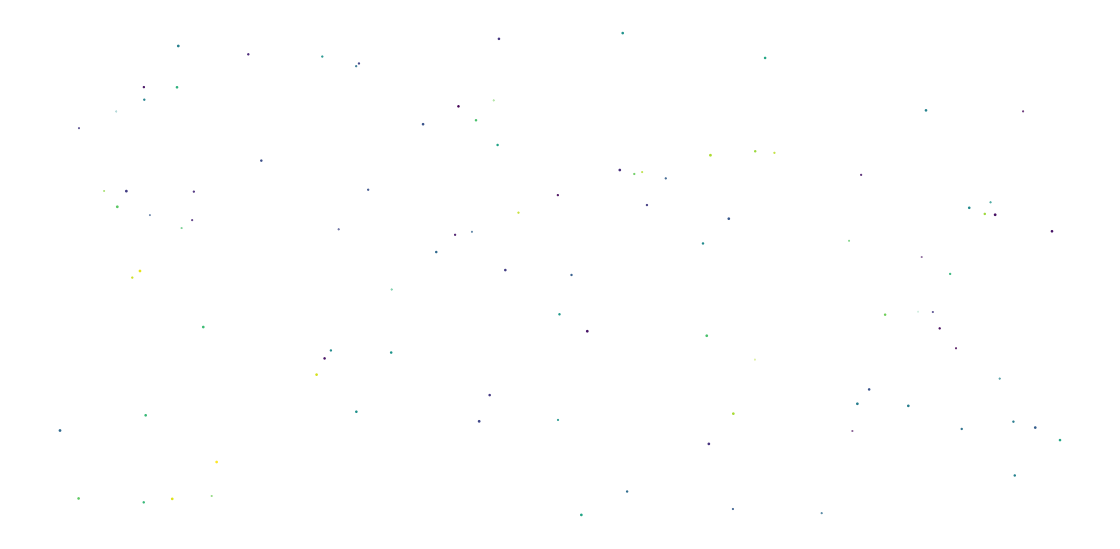

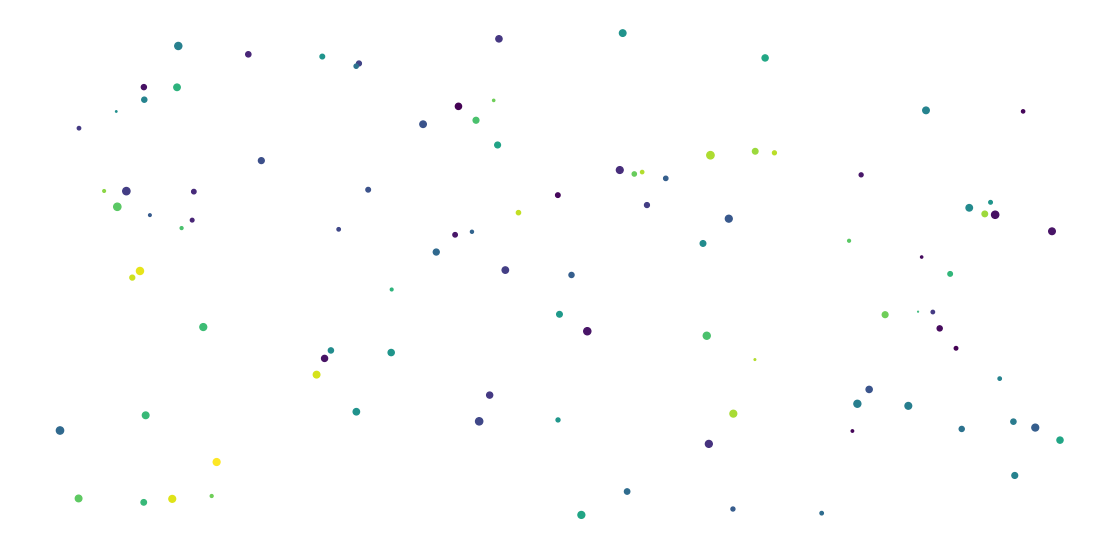

Error in callback <function flush_figures at 0x000002012364CD60> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [1]:
import customtkinter as ctk
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class ctkApp:
        
    def __init__(self):
        ctk.set_appearance_mode("dark")
        self.root = ctk.CTk()
        self.root.geometry("1200x400+200x200")
        self.root.title("Dynamic Scatterplot")
        self.root.update()
        self.frame = ctk.CTkFrame(master=self.root,
                                  height= self.root.winfo_height()*0.95,
                                  width = self.root.winfo_width()*0.66,
                                  fg_color="darkblue")
        self.frame.place(relx=0.33, rely=0.025)
        self.input =  ctk.CTkEntry(master=self.root,
                                   placeholder_text=100,
                                   justify='center',
                                   width=300,
                                   height=50,
                                   fg_color="darkblue")
        self.input.insert(0,100)
        self.input.place(relx=0.025,rely=0.5)
        self.slider = ctk.CTkSlider(master=self.root,
                                    width=300,
                                    height=20,
                                    from_=1,
                                    to=1000,
                                    number_of_steps=999,
                                    command=self.update_surface)
        self.slider.place(relx= 0.025,rely=0.75) 
        self.button = ctk.CTkButton(master = self.root,
                               text="Update Graph",
                               width=300,
                               height=50,
                               command=self.update_window)
        self.button.place(relx=0.025,rely=0.25)
        self.root.mainloop()
    
    def update_window(self):
        fig, ax = plt.subplots()
        fig.set_size_inches(11,5.3)
        global x,y,s,c
        x,y,s,c = np.random.rand(4,int(self.input.get()))
        ax.scatter(x,y,s*self.slider.get(),c)
        ax.axis("off")
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
        canvas = FigureCanvasTkAgg(fig,master=self.root)
        canvas.draw()
        canvas.get_tk_widget().place(relx=0.33, rely=0.025)
        self.root.update()
        
    def update_surface(self,other):
        fig, ax = plt.subplots()
        fig.set_size_inches(11,5.3)
        ax.scatter(x,y,s*self.slider.get(),c)
        ax.axis("off")
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0, hspace=0)
        canvas = FigureCanvasTkAgg(fig,master=self.root)
        canvas.draw()
        canvas.get_tk_widget().place(relx=0.33, rely=0.025)
        self.root.update()

if __name__ == "__main__":        
    CTK_Window = ctkApp()